In [ ]:
import torch
import pandas as pd
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.utils
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
base_path = Path('/content/drive/MyDrive/wdrozenie/data')

Mounted at /content/drive


# Przygotowanie danych

Ustawione ziarno.

In [ ]:
torch.manual_seed(1)

Pobranie danych.

In [ ]:
transform = transforms.ToTensor()

trainset = datasets.FashionMNIST(
    root=base_path,
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root=base_path,
    train=False,
    download=True,
    transform=transform,
)

Sprawdzenie wymiarów przykładowego obrazu. Obraz ma wymiary 28x28 pikseli oraz 1 kanał.

In [ ]:
trainset[0][0].shape

torch.Size([1, 28, 28])

Prezentacja przykładowych próbek.

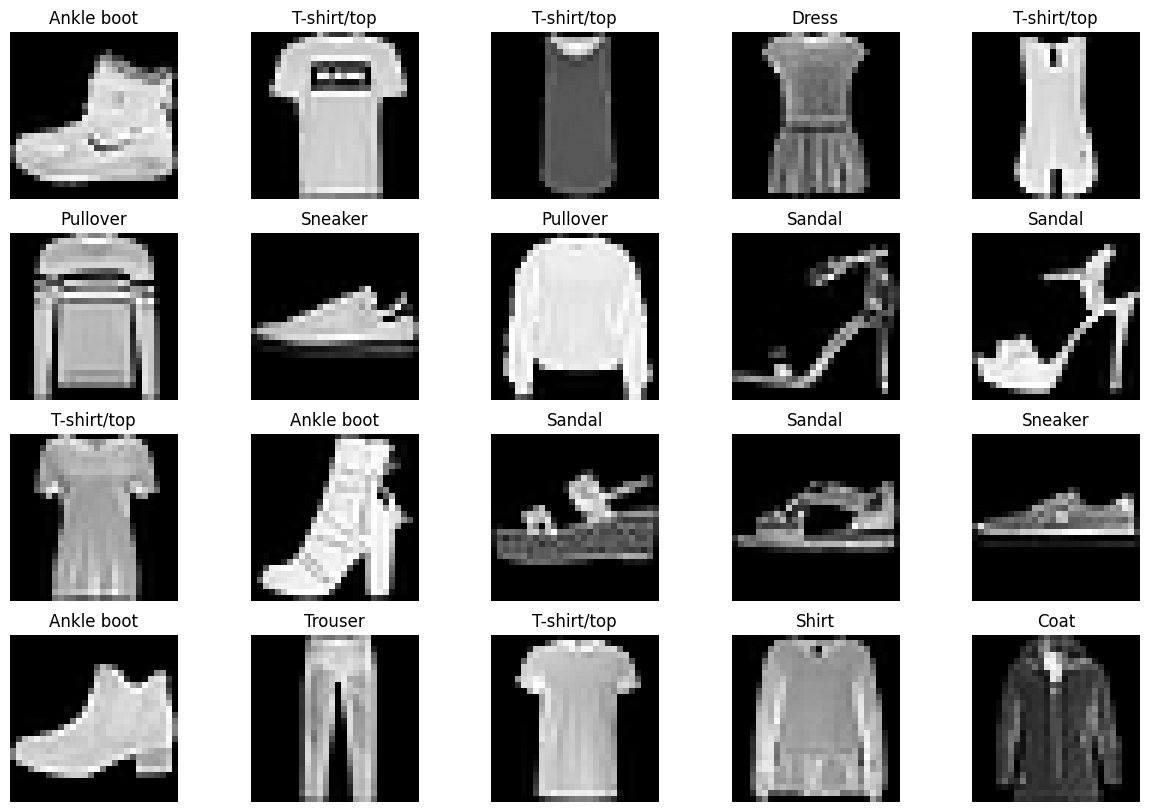

In [ ]:
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(15, 10))
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.title(target_names[trainset[i][1]])
  plt.imshow(trainset[i][0].permute(1, 2, 0), cmap='grey')
  plt.axis('off')

Poniżej sprawdziłem rozkład klas w zbiorach treningowym i testowym oraz jak wygląda uśredniony obraz dla każdego z tych zbiorów. Zauważyć można, że zbiory te są praktycznie idealnie zbalansowane oraz zachowany jest podobny rozkład między zbiorem treningowym a testowym.

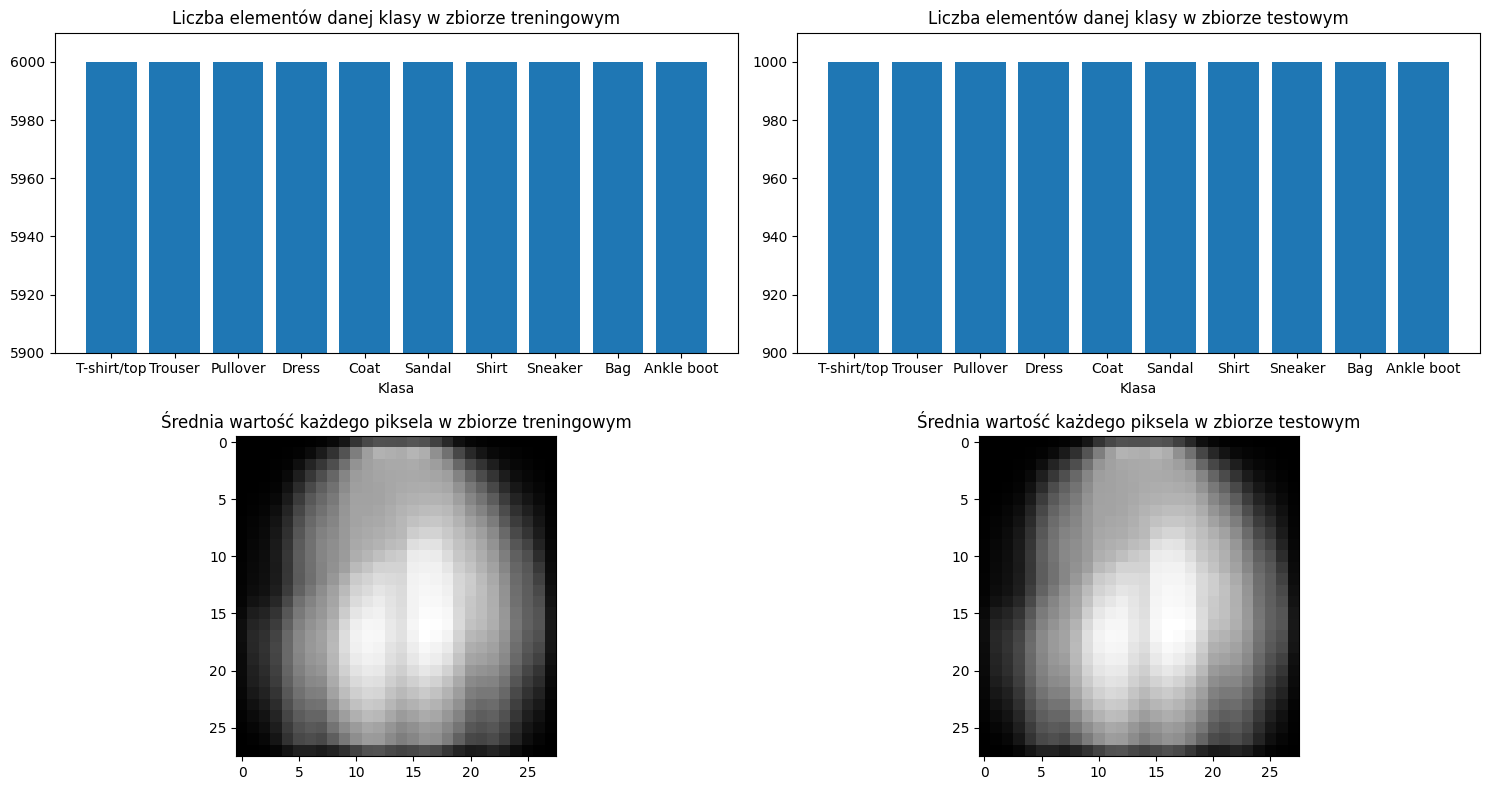

In [ ]:
def plot_classes_numerosities_and_avg_pixel_value(data, data_name, bottom_lim, plot_num=1):
  class_counts = torch.bincount(data.targets)

  # liczność klas
  plt.subplot(2, 2, plot_num)
  plt.bar(target_names, class_counts.numpy())
  plt.title(f'Liczba elementów danej klasy w zbiorze {data_name}')
  plt.xlabel('Klasa')
  plt.ylim(bottom_lim, class_counts.max().item() + 10) # wymuszenie dolnej granicy wykresu w celu lepszego przyjrzenia się rozkładowi

  # uśredniony obraz całego zbioru danych
  plt.subplot(2, 2, plot_num+2)
  plt.title(f'Średnia wartość każdego piksela w zbiorze {data_name}')
  plt.imshow(torch.stack([data[i][0] for i in range(len(data))]).mean(dim=0).permute(1, 2, 0), cmap='grey')

plt.figure(figsize=(15, 8))
plot_classes_numerosities_and_avg_pixel_value(trainset, 'treningowym', 5900)
plot_classes_numerosities_and_avg_pixel_value(testset, 'testowym', 900, plot_num=2)

plt.tight_layout()
plt.show()

Utworzenie dataloaderów.

In [ ]:
batch_size = 128
train_size = int(0.8 * len(trainset))
train_data, validation_data = torch.utils.data.random_split(trainset, [train_size, len(trainset) - train_size])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Model

Kod definiujący mojego MLP. W obrębie całej sieci zastosowana została funkcja aktywacji ReLu. Zrezygnowałem z użycia sigmoid'u z ostatniej warstwy sieci, jako że w tym zadaniu nie potrzeba wyznaczania prawdopodobieństwa poszczególnych klas, lecz potrzebne jest tylko wyznaczenie klasy z najwyższą wartością.

In [ ]:
class ParametrizedMLP(nn.Module):

  def __init__(self, hidden_layers, inputs=28*28, outputs=10, batch_norm=False, dropout=0.0):
    super().__init__()
    layers = [nn.Flatten()] # zainicjowanie listy warstw od spłaszczenia danych wejściowych
    in_features = inputs
    # petla do dodawania warstw ukrytych do listy
    for layer in hidden_layers:
      layers.append(nn.Linear(in_features, layer))
      layers.append(nn.ReLU())    # użycie ReLu
      if batch_norm:      # miejsce na batch norm
        layers.append(nn.BatchNorm1d(layer))
      if dropout > 0.0:   # i na dropout
        layers.append(nn.Dropout(dropout))
      in_features = layer
    layers.append(nn.Linear(in_features, outputs)) # dodanie warstwy końcowej
    # zapakowanie warstw do nn.Sequential, aby uprościć funkcję forward() poniżej
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

# Kod treningowy

Kod do trenowania modelu. Nie licząc kostruktora, klasa składa się z 5 funkcji. `traninng_loop` stanowi szkielet całego algorytmu pętli uczenia, wliczając w to m.in. wyświetlanie funkcji straty, czy zapisywanie modelu. Z poziomu tej funkcji wywoływana jest reszta funkcji: `train` do treningu modelu, `evaluate` do jego oceny, `get_metrics` do pozykania metryk oraz `create_metrics_dataframe` do utworzenia ramki danych z pozyskanych metryk.

In [ ]:
class TrainingClass:

  def __init__(self, model, device, loss_fn, optimizer, early_stopping=False, scheduler=None):
    super().__init__()
    self.model = model
    self.model.to(device)

    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device
    self.early_stopping = early_stopping
    self.scheduler = scheduler

  def training_loop(self, epochs, model_name):
    # inicjalizacja list zwracanych przez funkcję
    training_losses = []
    validation_losses = []

    train_metrics = []
    validation_metrics = []

    training_accuracies = []
    validation_accuracies = []

    best_loss = float('inf')
    patience = 5
    wait = 0
    for epoch in range(epochs):
      # trening
      self.train(trainloader)
      # ewaluacja zbioru treningowego
      train_loss = self.evaluate(trainloader)
      training_losses.append(train_loss)
      # walidacja zbiorem walidacyjnym
      loss = self.evaluate(validationloader)
      validation_losses.append(loss)

      # scheduler
      if self.scheduler is not None:
        self.scheduler.step()
        current_lr = self.optimizer.param_groups[0]['lr']
        print(f"LR: {current_lr:.4f}")

      # pozyskanie metryk dla zbiorów treningowego i walidacyjnego
      metrics = self.get_metrics(trainloader)
      train_df, train_acc = self.create_metrics_dataframe(metrics)
      metrics = self.get_metrics(validationloader)
      val_df, val_acc = self.create_metrics_dataframe(metrics)

      training_accuracies.append(train_acc)
      validation_accuracies.append(val_acc)

      train_metrics.append(train_df)
      validation_metrics.append(val_df)

      # zapamiętanie najlepszego modelu
      if loss < best_loss:
        best_loss = loss
        wait = 0
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/mlp-models/{model_name}_weights.pth')
      else:
        wait += 1
        # early stopping
        if self.early_stopping and wait >= patience:
          print(f'Early stopping at epoch {epoch+1}')
          break
      # wyświetlanie statusu
      if epoch < 5 or (epoch % 5) == 4: # od piątej epoki ograniczenie wyświetlania na co piątą epokę aby nie zaśmieciać notatnika output'em xd
        print(f'epoch: {epoch+1}, train loss: {train_loss:.3f}, validation loss: {loss:.3f}')

    # końcowa ewaluacja zbiorem testowym
    test_loss = self.evaluate(testloader)
    print(f'test loss: {test_loss:.3f}')

    return training_losses, validation_losses, train_metrics, validation_metrics, training_accuracies, validation_accuracies

  # funkcja do treningu modelu
  def train(self, dataloader):
    self.model.train()
    for i, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(self.device), labels.to(self.device)
      self.optimizer.zero_grad()
      predictions = self.model(inputs)
      loss = self.loss_fn(predictions, labels)

      loss.backward()
      self.optimizer.step()

  # funkcja do oceny modelu na wybranym dataloaderze
  def evaluate(self, dataloader):
    self.model.eval()
    with torch.no_grad():
      total_loss = 0.0
      for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        # sumowanie straty z każdego batch'a dataloader'a
        total_loss += self.loss_fn(self.model(inputs), labels).item()
    # wydobycie średniej
    return total_loss / len(dataloader)

  # pozyskanie metryk
  def get_metrics(self, dataloader):
    self.model.eval()
    all_labels = []       # lista wartości rzeczywistych
    all_predictions = []  # lista wartości przewidzianych przez model
    with torch.no_grad():
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        outputs = self.model(inputs)
        _, predicted = torch.max(outputs.data, 1) # wydobycie klasy o największej wartości (sama wartość jest pomijana ("_"))
        all_labels.append(labels)
        all_predictions.append(predicted)

    all_labels = torch.cat(all_labels).cpu().numpy()
    all_predictions = torch.cat(all_predictions).cpu().numpy()
    return classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0, output_dict=True)

  # funkcja do przetworzenia classification_report z funkcji get_metrics do postaci DataFrame
  def create_metrics_dataframe(self, metrics):
    data = {}
    acc = metrics.pop('accuracy') # pobranie accuracy
    for key, value in metrics.items():
      # pobranie informacji o precision, recall, f1 per klasa
      if key in target_names:
        for k, v in value.items():
          if k != 'support':
            if k not in data:
              data[k] = {}
            data[k][key] = v
    df = pd.DataFrame.from_dict(data, orient='index')
    df.index.name = 'metric'
    return df, acc

# Kod do wizualizacji

Wydzielenie kodu do wizualizacji, aby nie powtarzać się z nim w eksperymentach. Poniżej zawarty jest kod do uworzenia wizualizacji funkcji straty i dokładności zarówno na zbiorze treningowym jak i walidacyjnym.

In [ ]:
# kod dla pojedynczego subplot
def plot_loss_and_accuracy(tr_list, val_list, function_name, plot_num=1):
  plt.subplot(1, 2, plot_num)
  plt.title(f'Wykres {function_name}')
  plt.plot(tr_list, label='trening')
  plt.plot(val_list, label='walidacja')
  plt.xlabel('Epoka')
  plt.legend()
  plt.grid(True)

# utworzenie wizualizacji dla funkcji straty i accuracy
def create_loss_and_accuracy_plot(tr_losses, val_losses, tr_accuracies, val_accuracies):
  plt.figure(figsize=(15, 5))
  plot_loss_and_accuracy(tr_losses, val_losses, 'funkcji straty', 1)
  plot_loss_and_accuracy(tr_accuracies, val_accuracies, 'dokładności', 2)

Następny kod służy do utworzenia wizualizacji pozostałych metryk (precision, recall, f1) osobno dla każdej klasy. Wizualizacje obejmują zarówno zbiór treningowy jak i walidacyjny, które odróżnione są jasnością barwy. Dla wyników zbioru treningowego przeznaczone są jaśniejsze odcienie a dla zbioru walidacyjnego ciemniejsze.

In [ ]:
train_colors = ['tomato', 'limegreen', 'cornflowerblue']
validation_colors = ['darkred', 'darkgreen', 'darkblue']

def plot_metrics(dataframes, dataframe_type, colors):
  for idx, col in enumerate(dataframes[0].columns): # pętla do utworzenia dla każdej klasy osobnego subplotu
    plt.subplot(5, 2, idx+1)
    # zebranie metryk z listy DataFrame do odpowiednich list
    precision = []
    recall = []
    f1 = []
    for metrics in dataframes:
      precision.append(metrics.loc['precision', col])
      recall.append(metrics.loc['recall', col])
      f1.append(metrics.loc['f1-score', col])
    # wykres
    plt.title(f'Metryki dla klasy {col}')
    plt.xlabel('Epoka')
    plt.ylim(-0.05, 1.05)
    plt.plot(precision, label=f'precision - {dataframe_type}', color=colors[0]) # czerwony dla precision
    plt.plot(recall, label=f'recall - {dataframe_type}', color=colors[1]) # zielony dla recall
    plt.plot(f1, label=f'f1-score - {dataframe_type}', color=colors[2]) # niebieski dla f1
    plt.legend()
    plt.grid(True)

# utworzenie wizualizacji dla pozostałych metryk (precision, recall, f1)
def create_metrics_plot(tr_metrics, val_metrics):
  plt.figure(figsize=(15, 20))
  plot_metrics(tr_metrics, 'trening', train_colors)
  plot_metrics(val_metrics, 'walidacja', validation_colors)
  plt.tight_layout()
  plt.show()

Ostatni kod służy do wizualizacji wag dla wybranej warstwy modelu. Zastosowanie .reshape() przekształca wagi do postaci czytelnej dla oka.

In [ ]:
def visualize_layer_weights(layer, layer_width, plot_grid, shape=(28, 28), axis='off'):
  weights_ = layer.weight.data.cpu().numpy()

  for i in range(layer_width):
      plt.subplot(plot_grid[0], plot_grid[1], i + 1)
      plt.imshow(weights_[i].reshape(shape), cmap='grey')
      plt.title(f'{i+1}')
      plt.axis(axis)
  plt.tight_layout()
  plt.show()

# Eksperymenty

Domyślna liczba epok.

In [ ]:
epochs_num = 100

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Uruchomienie modelu bazowego. Zauważyc można (szczególnie po funkcji straty) overfitting modelu. Dodatkowo na wizualizacjach pozostałych metryk dostrzec można, że model radzi sobie najlepiej z klasami najbardziej odróżniającymi się od pozostałych (typu torebka, sandały, tenisówki i buty). Dla klass podobnych do siebie takich jak koszule, T-shirty, czy płaszcze model wykazuje nieco mniejszą skuteczność.

epoch: 1, train loss: 0.455, validation loss: 0.467
epoch: 2, train loss: 0.411, validation loss: 0.431
epoch: 3, train loss: 0.380, validation loss: 0.410
epoch: 4, train loss: 0.357, validation loss: 0.389
epoch: 5, train loss: 0.332, validation loss: 0.374
epoch: 10, train loss: 0.278, validation loss: 0.337
epoch: 15, train loss: 0.227, validation loss: 0.320
epoch: 20, train loss: 0.199, validation loss: 0.323
epoch: 25, train loss: 0.182, validation loss: 0.340
epoch: 30, train loss: 0.153, validation loss: 0.350
epoch: 35, train loss: 0.137, validation loss: 0.365
epoch: 40, train loss: 0.121, validation loss: 0.387
epoch: 45, train loss: 0.117, validation loss: 0.418
epoch: 50, train loss: 0.094, validation loss: 0.435
epoch: 55, train loss: 0.102, validation loss: 0.473
epoch: 60, train loss: 0.077, validation loss: 0.459
epoch: 65, train loss: 0.078, validation loss: 0.514
epoch: 70, train loss: 0.081, validation loss: 0.561
epoch: 75, train loss: 0.060, validation loss: 0.57

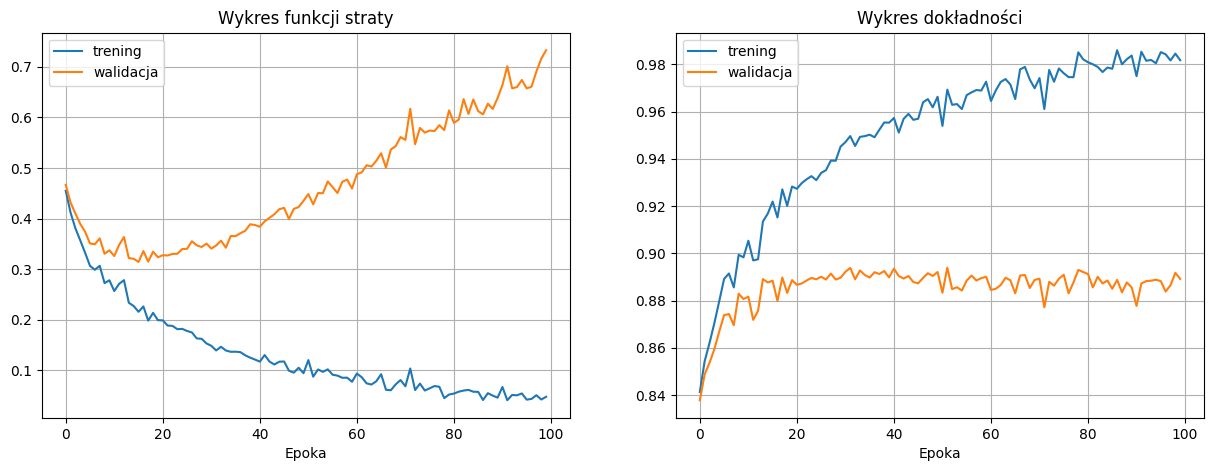

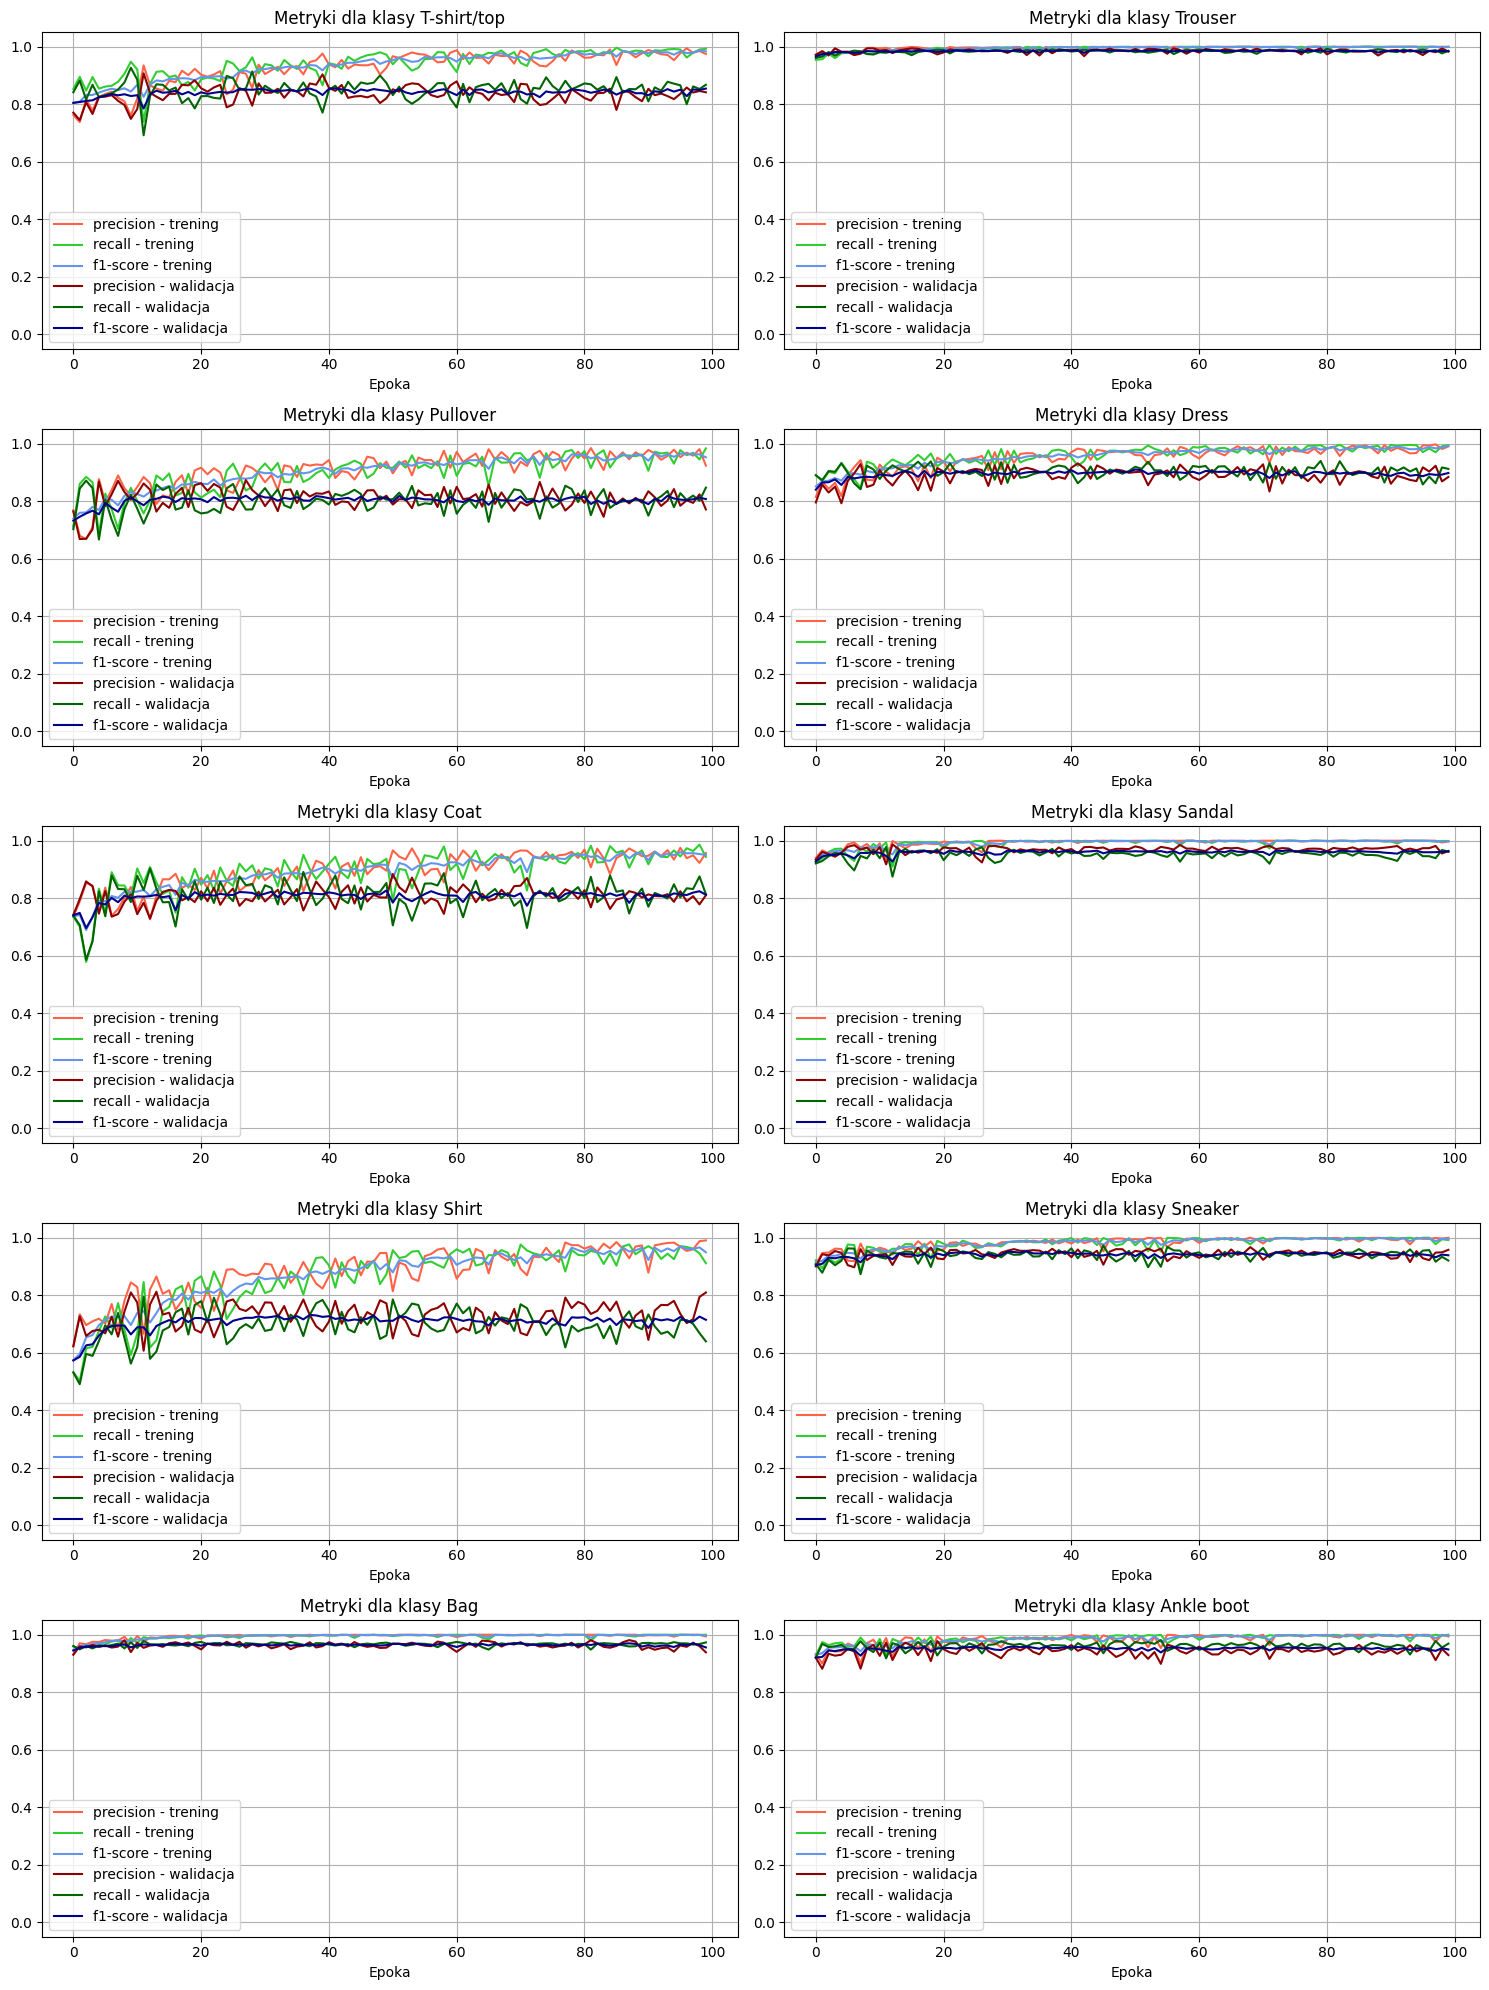

In [ ]:
# basic model
mlp = ParametrizedMLP([100, 50])
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters()))
tr_losses, val_losses, tr_metrics, val_metrics, tr_accuracies, val_accuracies = trainer.training_loop(epochs_num, "model-bazowy")

create_loss_and_accuracy_plot(tr_losses, val_losses, tr_accuracies, val_accuracies)
create_metrics_plot(tr_metrics, val_metrics)

Wizualizacja wag pierwszej warstwy. Zauważyć można na wielu z nich filtrowanie kształtu podobnego do płaszcza czy koszuli (czarny kolor oznacza małe wagi a biały wysokie wagi) oraz kilka niewykorzystanych neuronów co widać po szumie w neuronach 4, 14, 15 itd., ale najpierw skupię się na zastosowaniu early stoppingu.

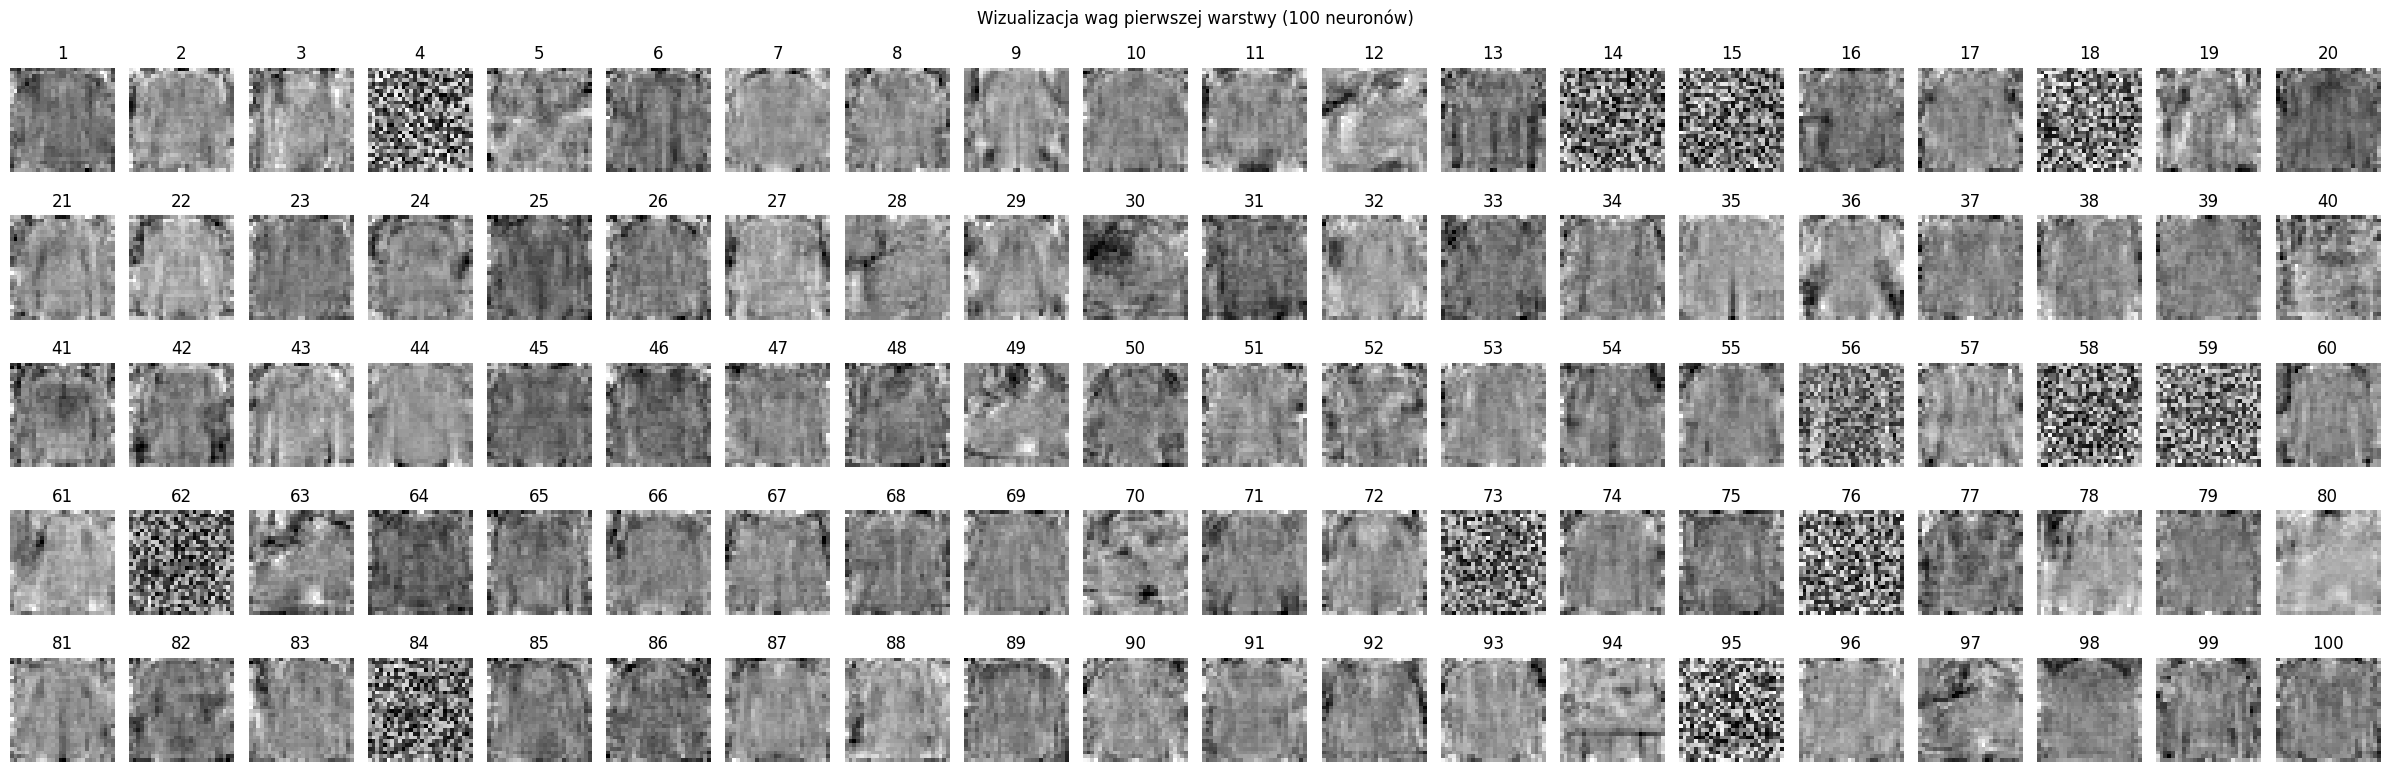

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50])

weights_path = '/content/drive/MyDrive/mlp-models/model-bazowy_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Uruchomienie modelu z early stopping. Jego zastosowanie zdecydowanie skróciło czas działania pętli uczenia, co widać po liczbie przeprowadzonych epok. W odróżnieniu od poprzedniego modelu, na wykresach metryk nie widać już aż tak dużego rozwarstwienia pomiędzy zbiorem treningowym a walidacyjnym.

epoch: 1, train loss: 0.459, validation loss: 0.470
epoch: 2, train loss: 0.406, validation loss: 0.431
epoch: 3, train loss: 0.374, validation loss: 0.404
epoch: 4, train loss: 0.339, validation loss: 0.369
epoch: 5, train loss: 0.330, validation loss: 0.366
epoch: 10, train loss: 0.271, validation loss: 0.332
epoch: 15, train loss: 0.225, validation loss: 0.315
epoch: 20, train loss: 0.199, validation loss: 0.322
Early stopping at epoch 23
test loss: 0.359


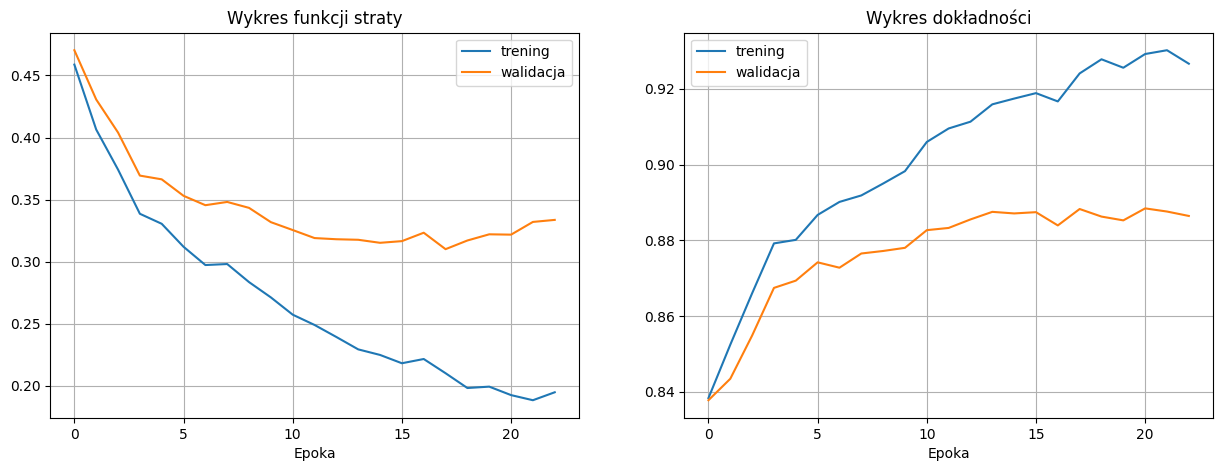

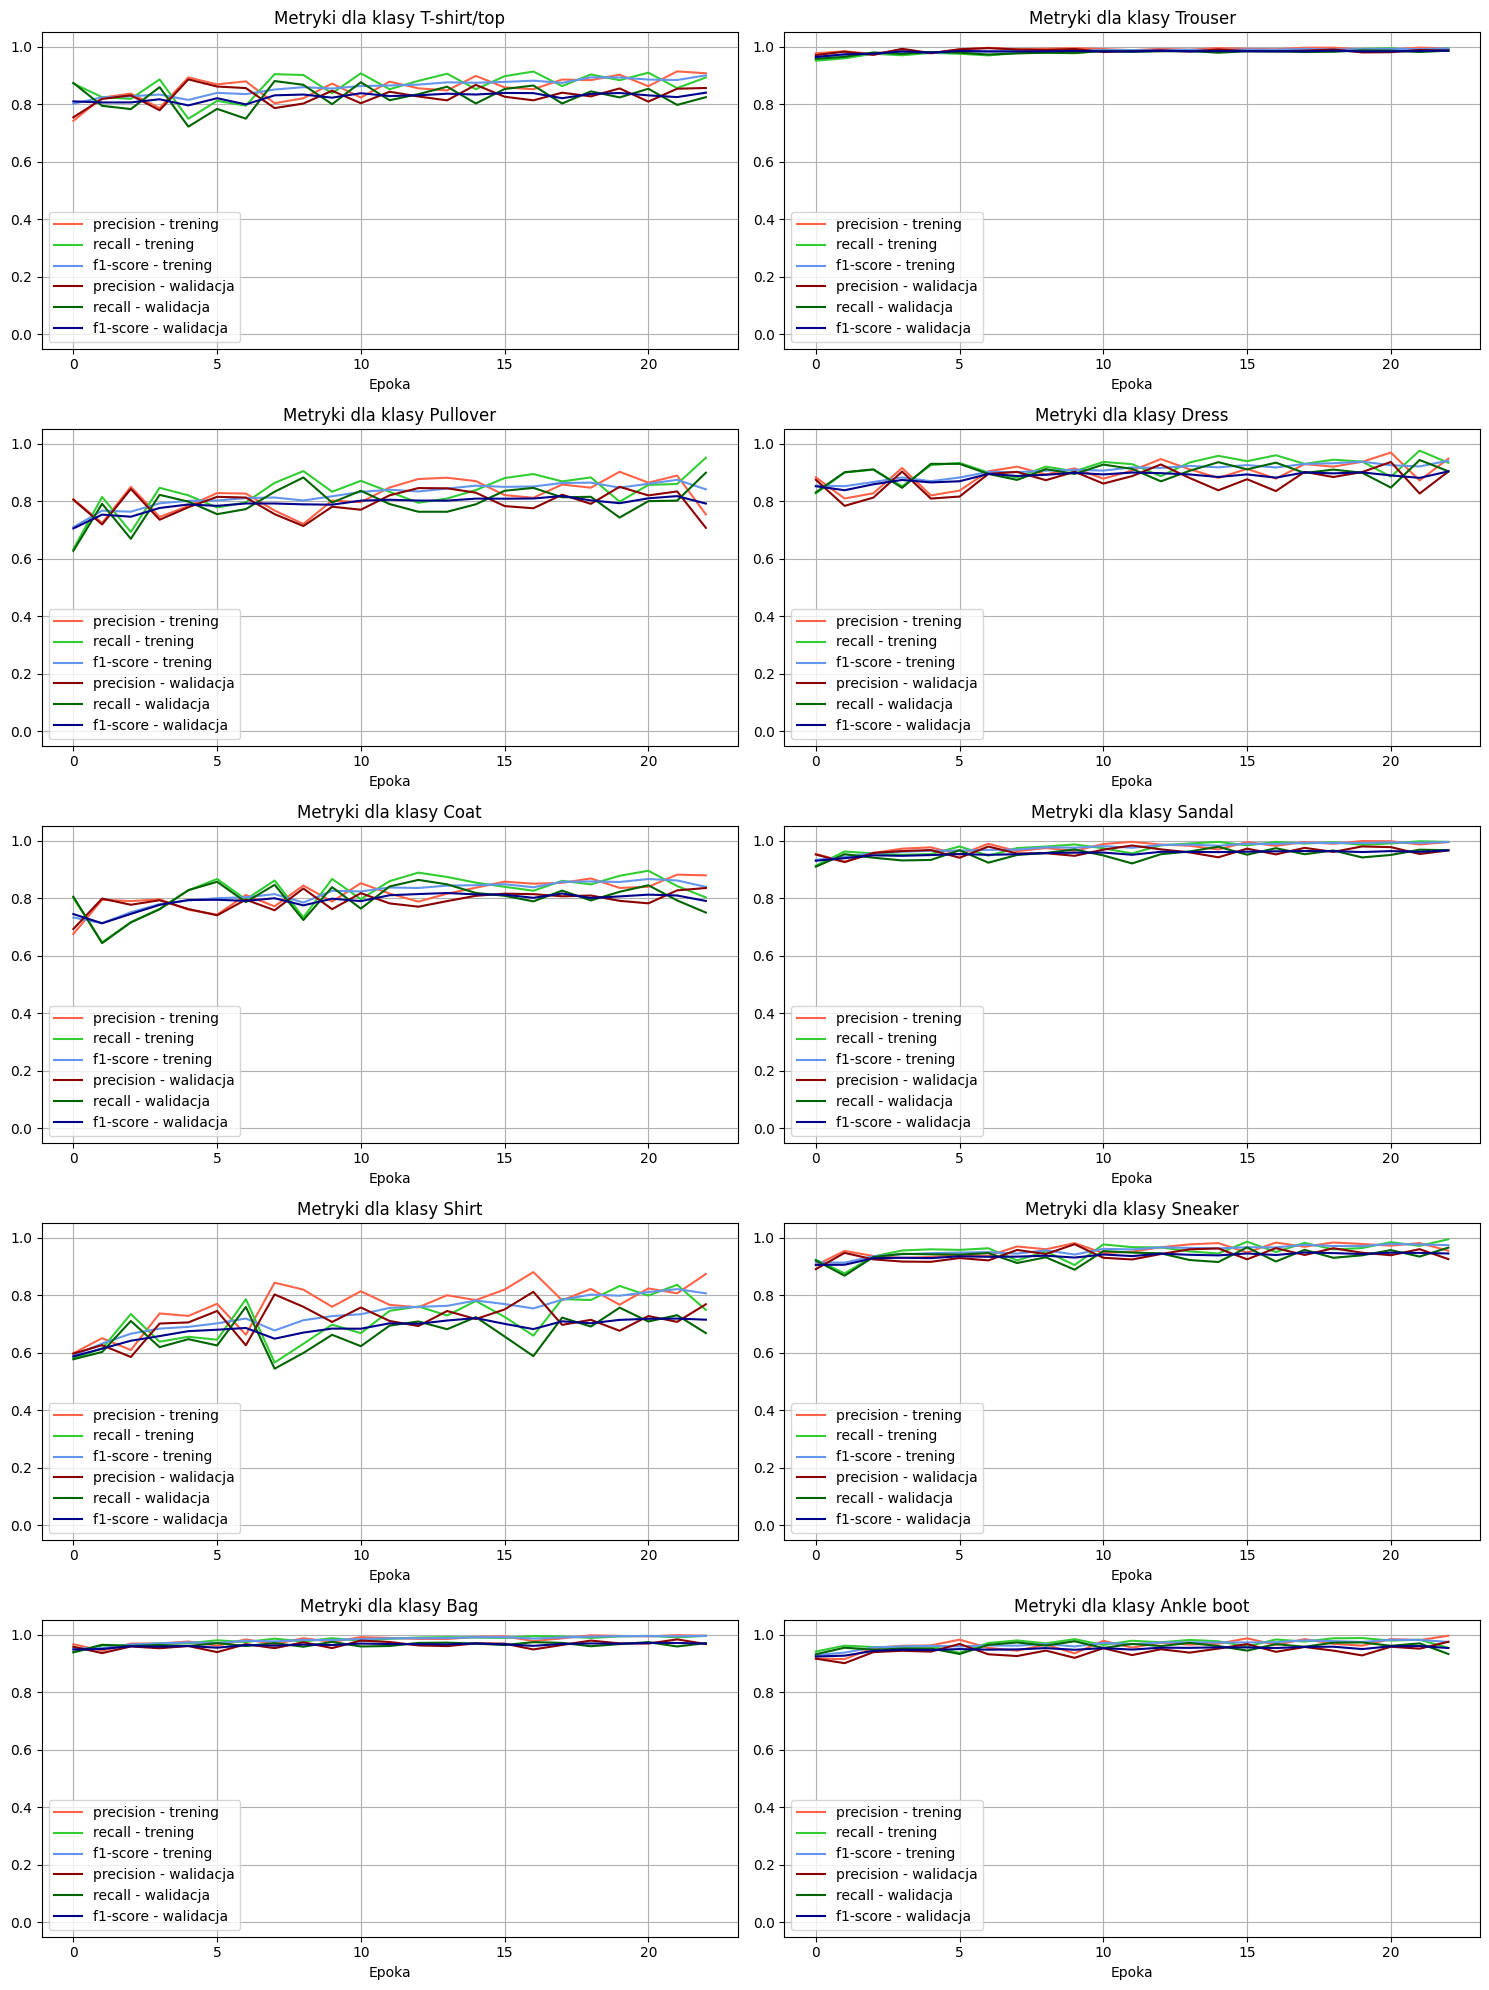

In [ ]:
# +early stopping
mlp = ParametrizedMLP([100, 50])
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters()), early_stopping=True)
tr_losses1, val_losses1, tr_metrics1, val_metrics1, tr_accuracies1, val_accuracies1 = trainer.training_loop(epochs_num, "model-early-stopping")

create_loss_and_accuracy_plot(tr_losses1, val_losses1, tr_accuracies1, val_accuracies1)
create_metrics_plot(tr_metrics1, val_metrics1)

Jako że w poprzednim eksperymencie zapisany model nie był aktualizowany w trakcie overfittingu to wagi wyglądają tutaj podobnie.

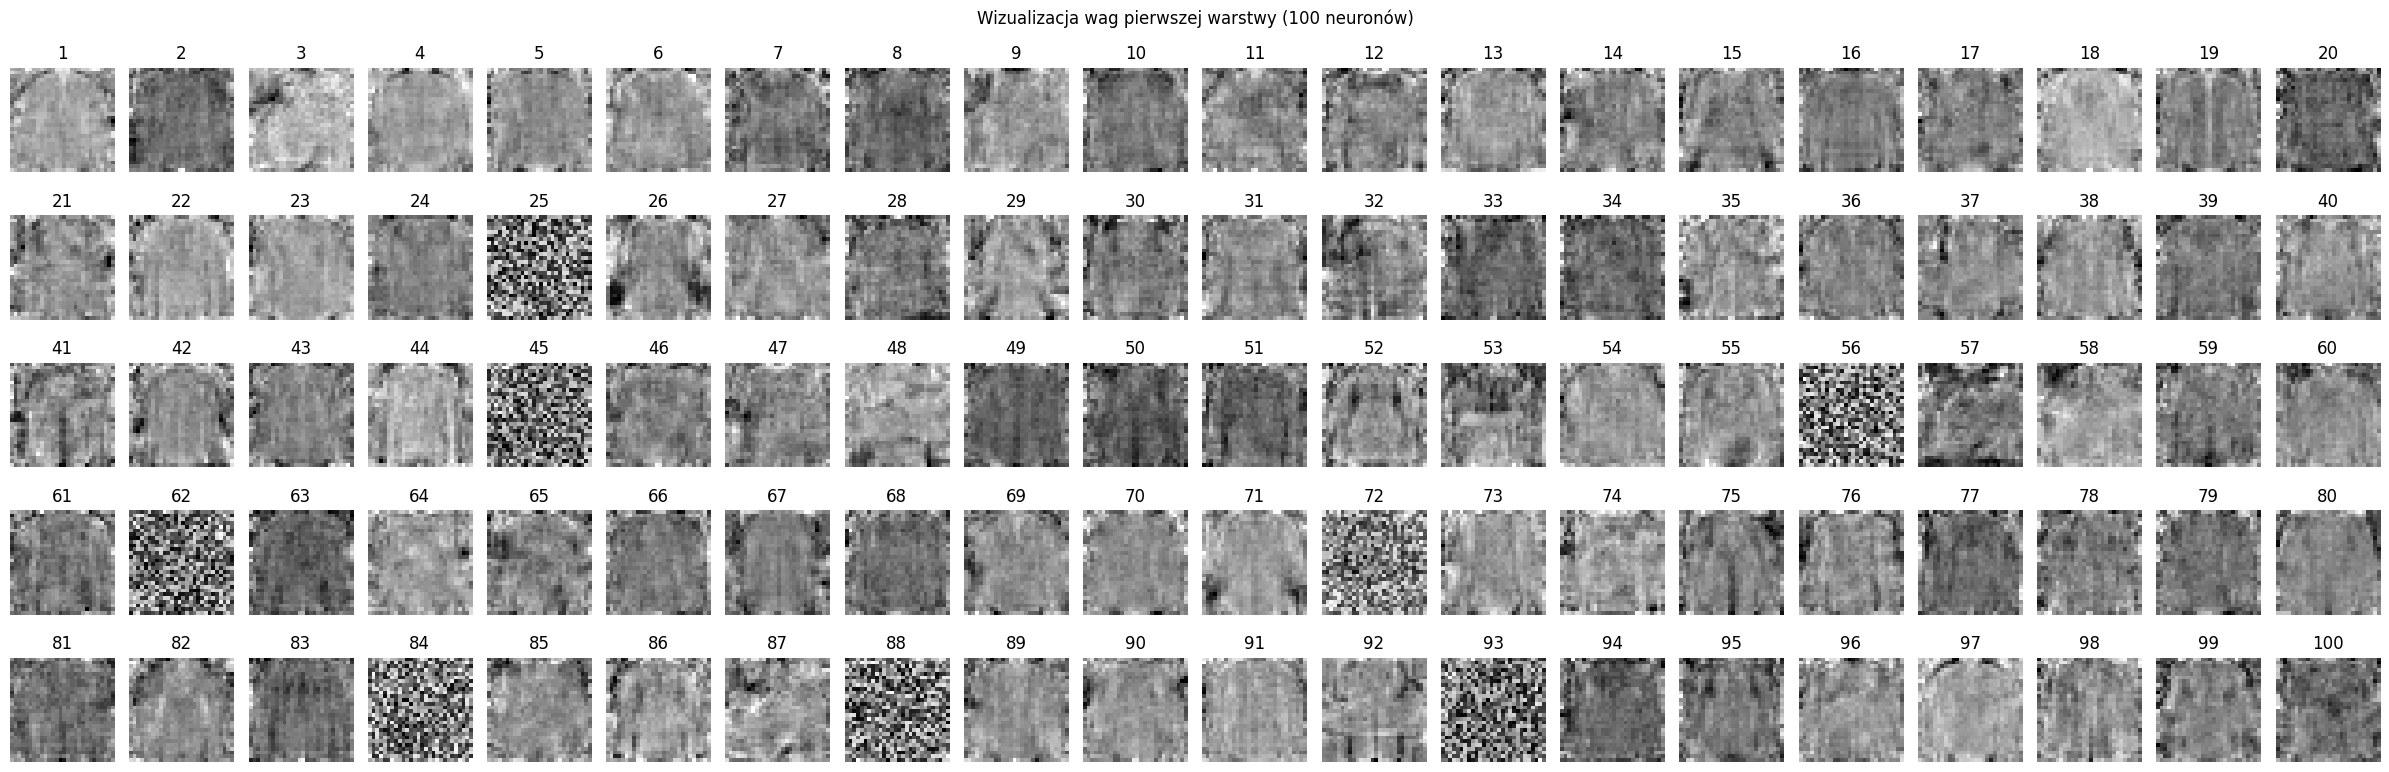

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50])

weights_path = '/content/drive/MyDrive/mlp-models/model-early-stopping_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Wypróbowanie modelu z mniejszą architekturą. Wykresy wskazują na nieznaczne pogorszenie się wyników. Nie dostrzeżono istotnych zmian w poszczególnych klasach.

epoch: 1, train loss: 0.503, validation loss: 0.513
epoch: 2, train loss: 0.419, validation loss: 0.438
epoch: 3, train loss: 0.401, validation loss: 0.421
epoch: 4, train loss: 0.379, validation loss: 0.404
epoch: 5, train loss: 0.362, validation loss: 0.392
epoch: 10, train loss: 0.313, validation loss: 0.364
epoch: 15, train loss: 0.302, validation loss: 0.366
epoch: 20, train loss: 0.263, validation loss: 0.350
epoch: 25, train loss: 0.231, validation loss: 0.336
Early stopping at epoch 30
test loss: 0.376


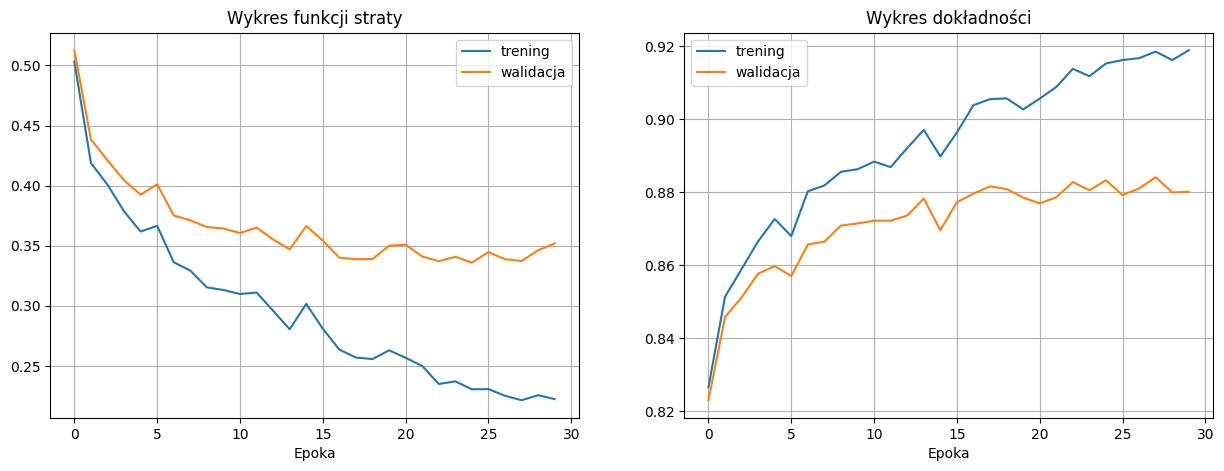

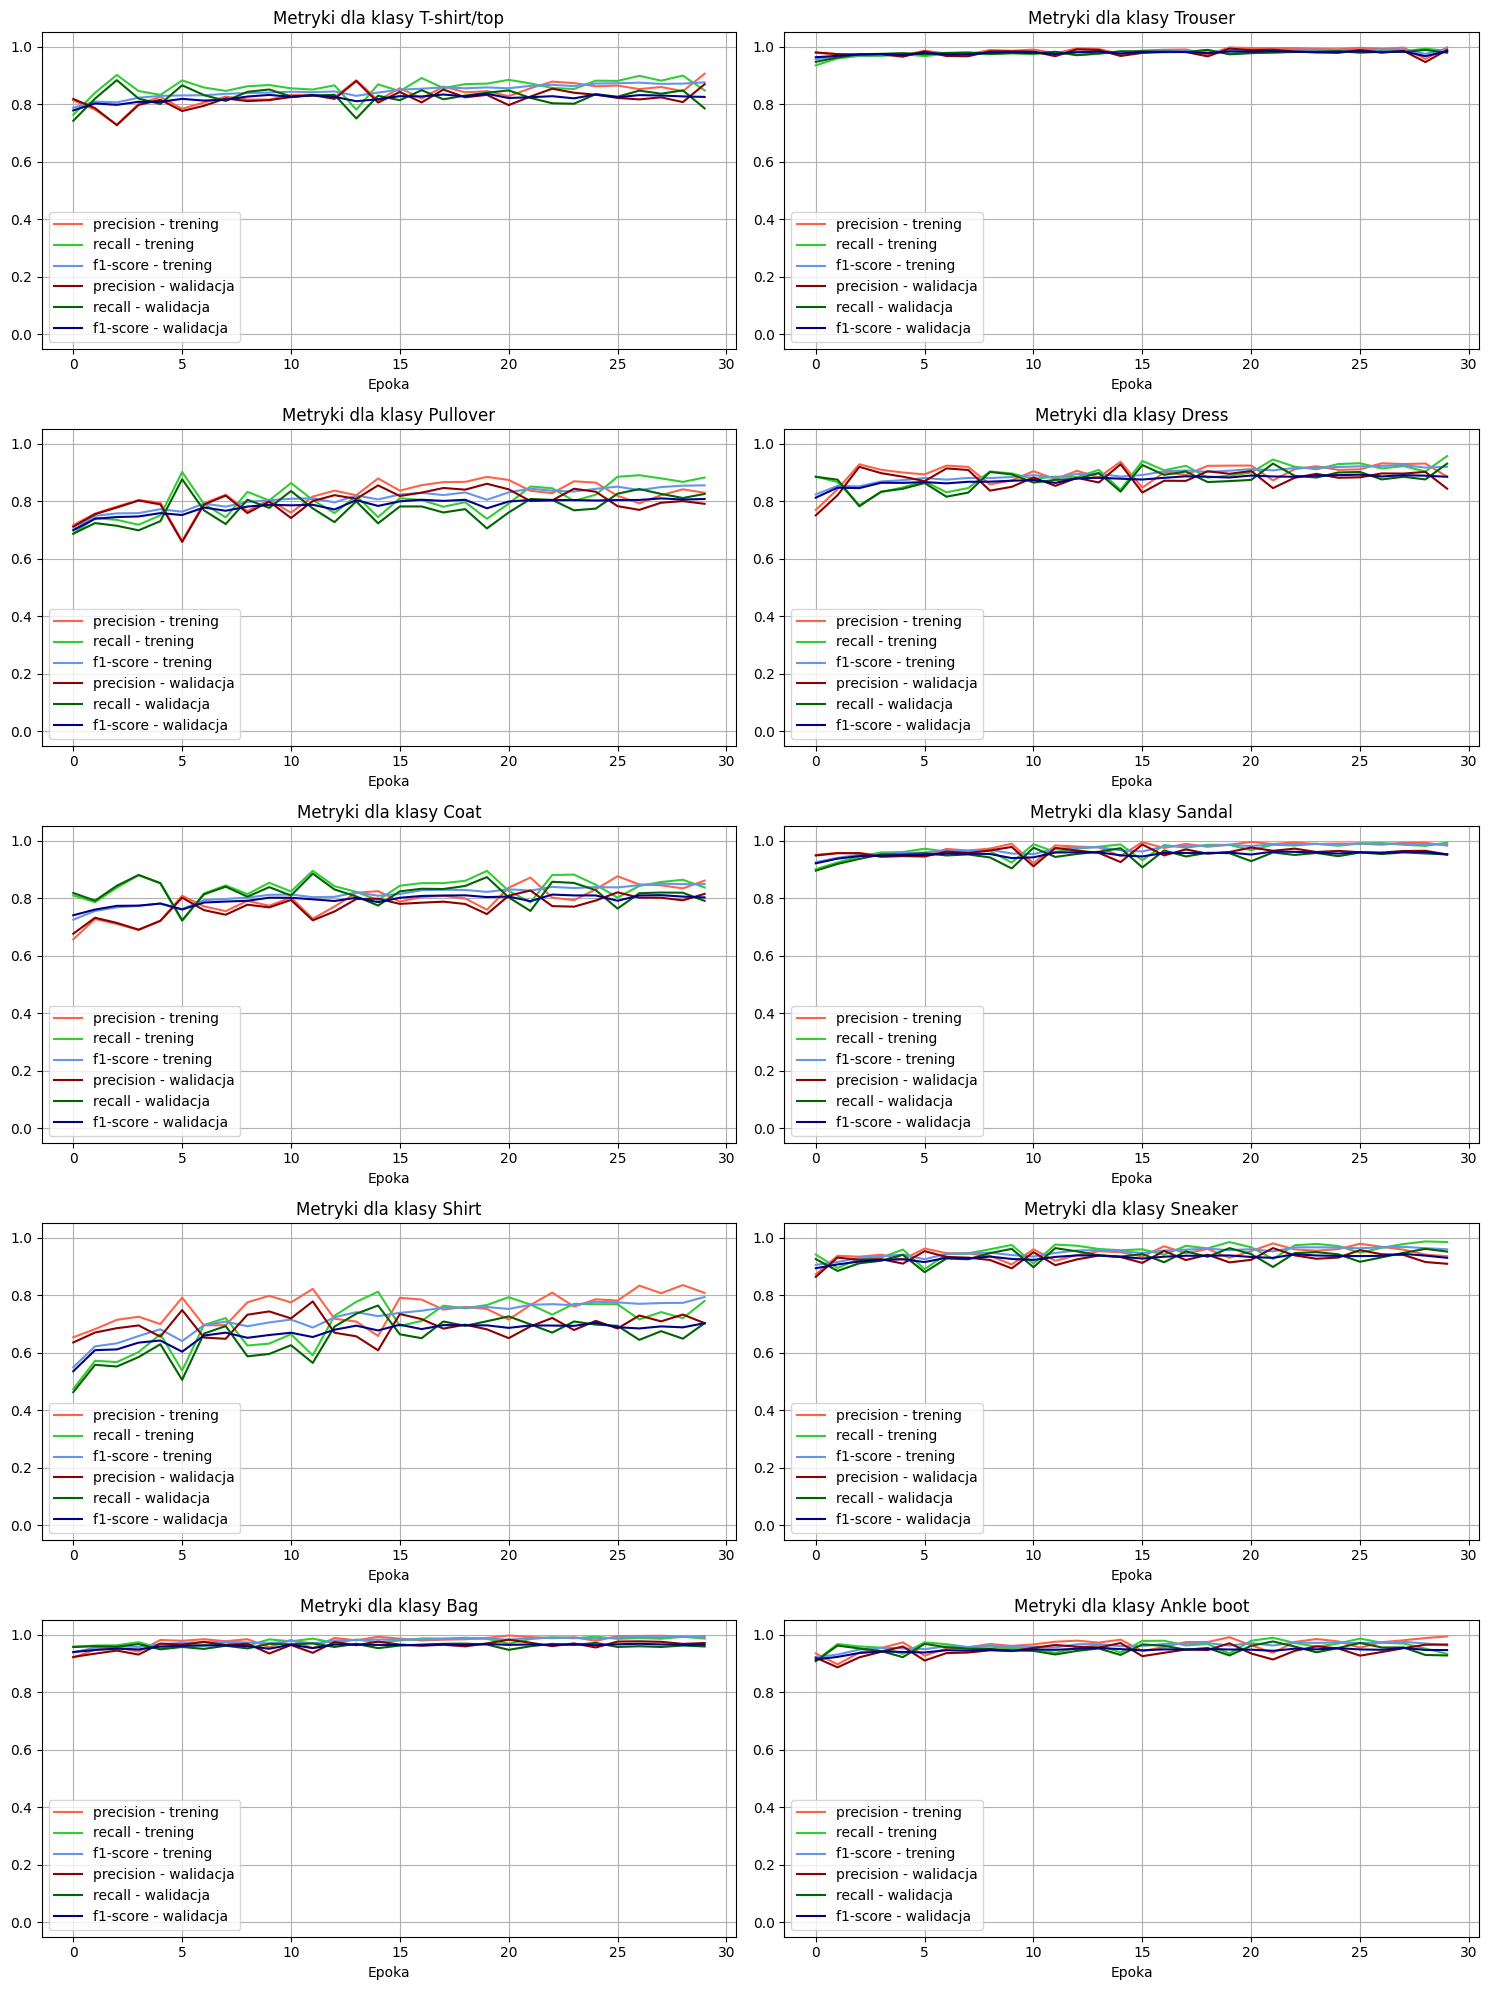

In [ ]:
# smaller architecture
mlp = ParametrizedMLP([50, 25])
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters()), early_stopping=True)
tr_losses2, val_losses2, tr_metrics2, val_metrics2, tr_accuracies2, val_accuracies2 = trainer.training_loop(epochs_num, "smaller-model")

create_loss_and_accuracy_plot(tr_losses2, val_losses2, tr_accuracies2, val_accuracies2)
create_metrics_plot(tr_metrics2, val_metrics2)

Poniższa wizualizacja wskazuje, że wagi pozostają podobne dla mniejszej architektury włącznie ze sporadycznie występującymi neuronami z szumem.

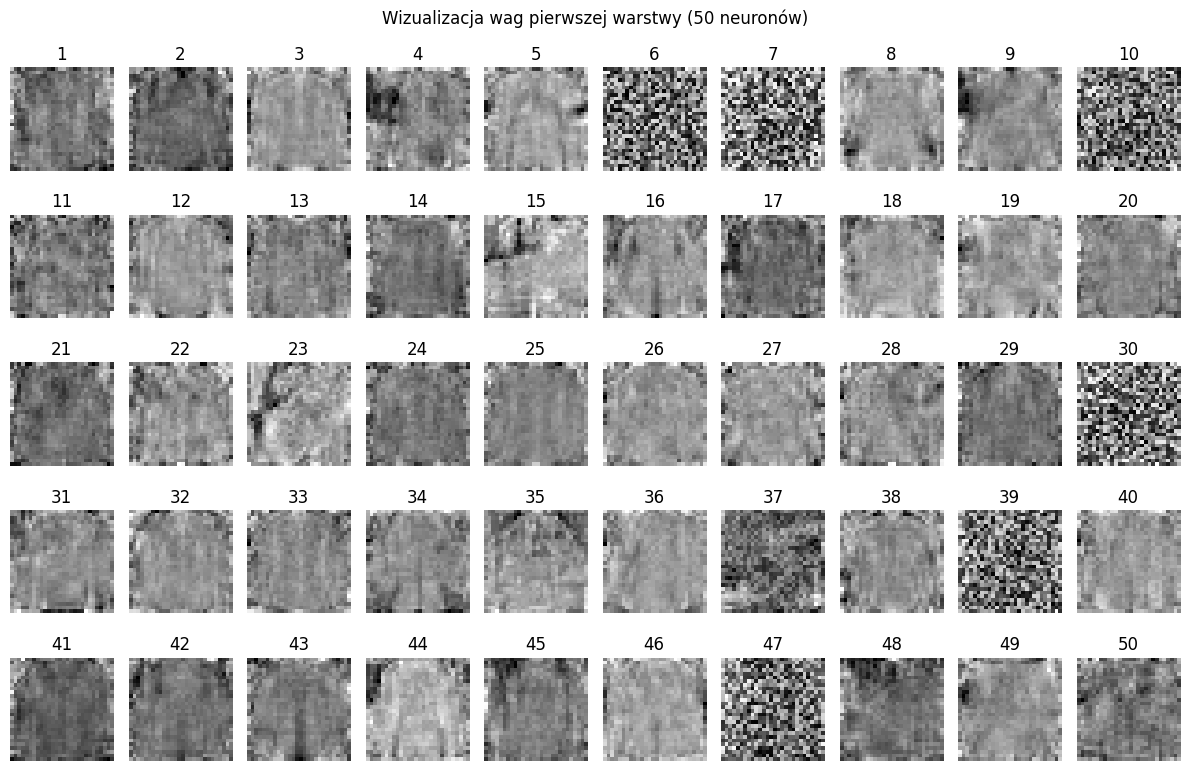

In [ ]:
mlp_visualize = ParametrizedMLP([50, 25])

weights_path = '/content/drive/MyDrive/mlp-models/smaller-model_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(12, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (50 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 50, [5, 10])

Wypróbowanie modelu z większą architekturą. Wykresy wskazują na wyniki porównywalne z architekturą bazową. Nie dostrzeżono istotnych zmian w poszczególnych klasach.

epoch: 1, train loss: 0.486, validation loss: 0.493
epoch: 2, train loss: 0.419, validation loss: 0.435
epoch: 3, train loss: 0.395, validation loss: 0.422
epoch: 4, train loss: 0.412, validation loss: 0.441
epoch: 5, train loss: 0.358, validation loss: 0.393
epoch: 10, train loss: 0.286, validation loss: 0.343
epoch: 15, train loss: 0.252, validation loss: 0.332
epoch: 20, train loss: 0.221, validation loss: 0.327
Early stopping at epoch 24
test loss: 0.361


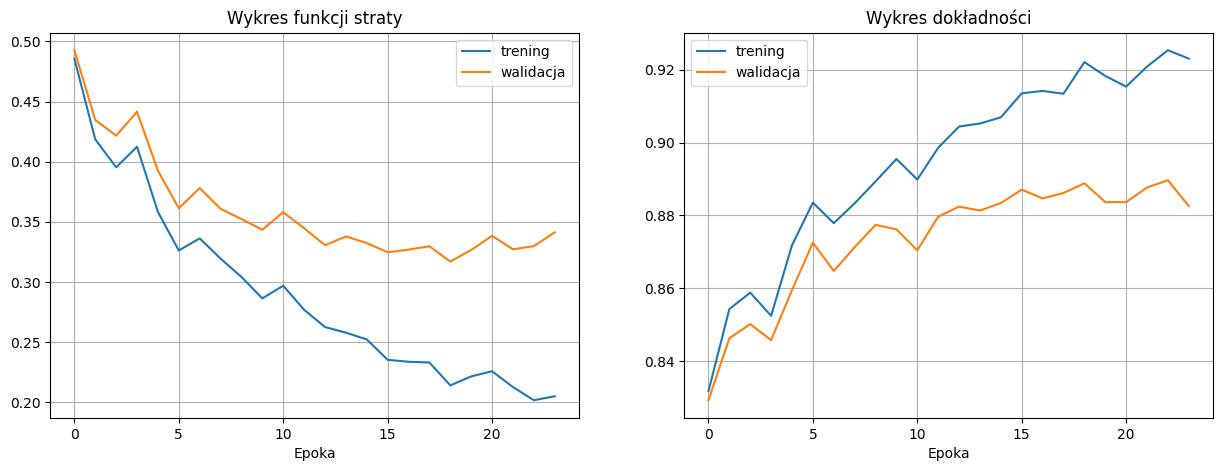

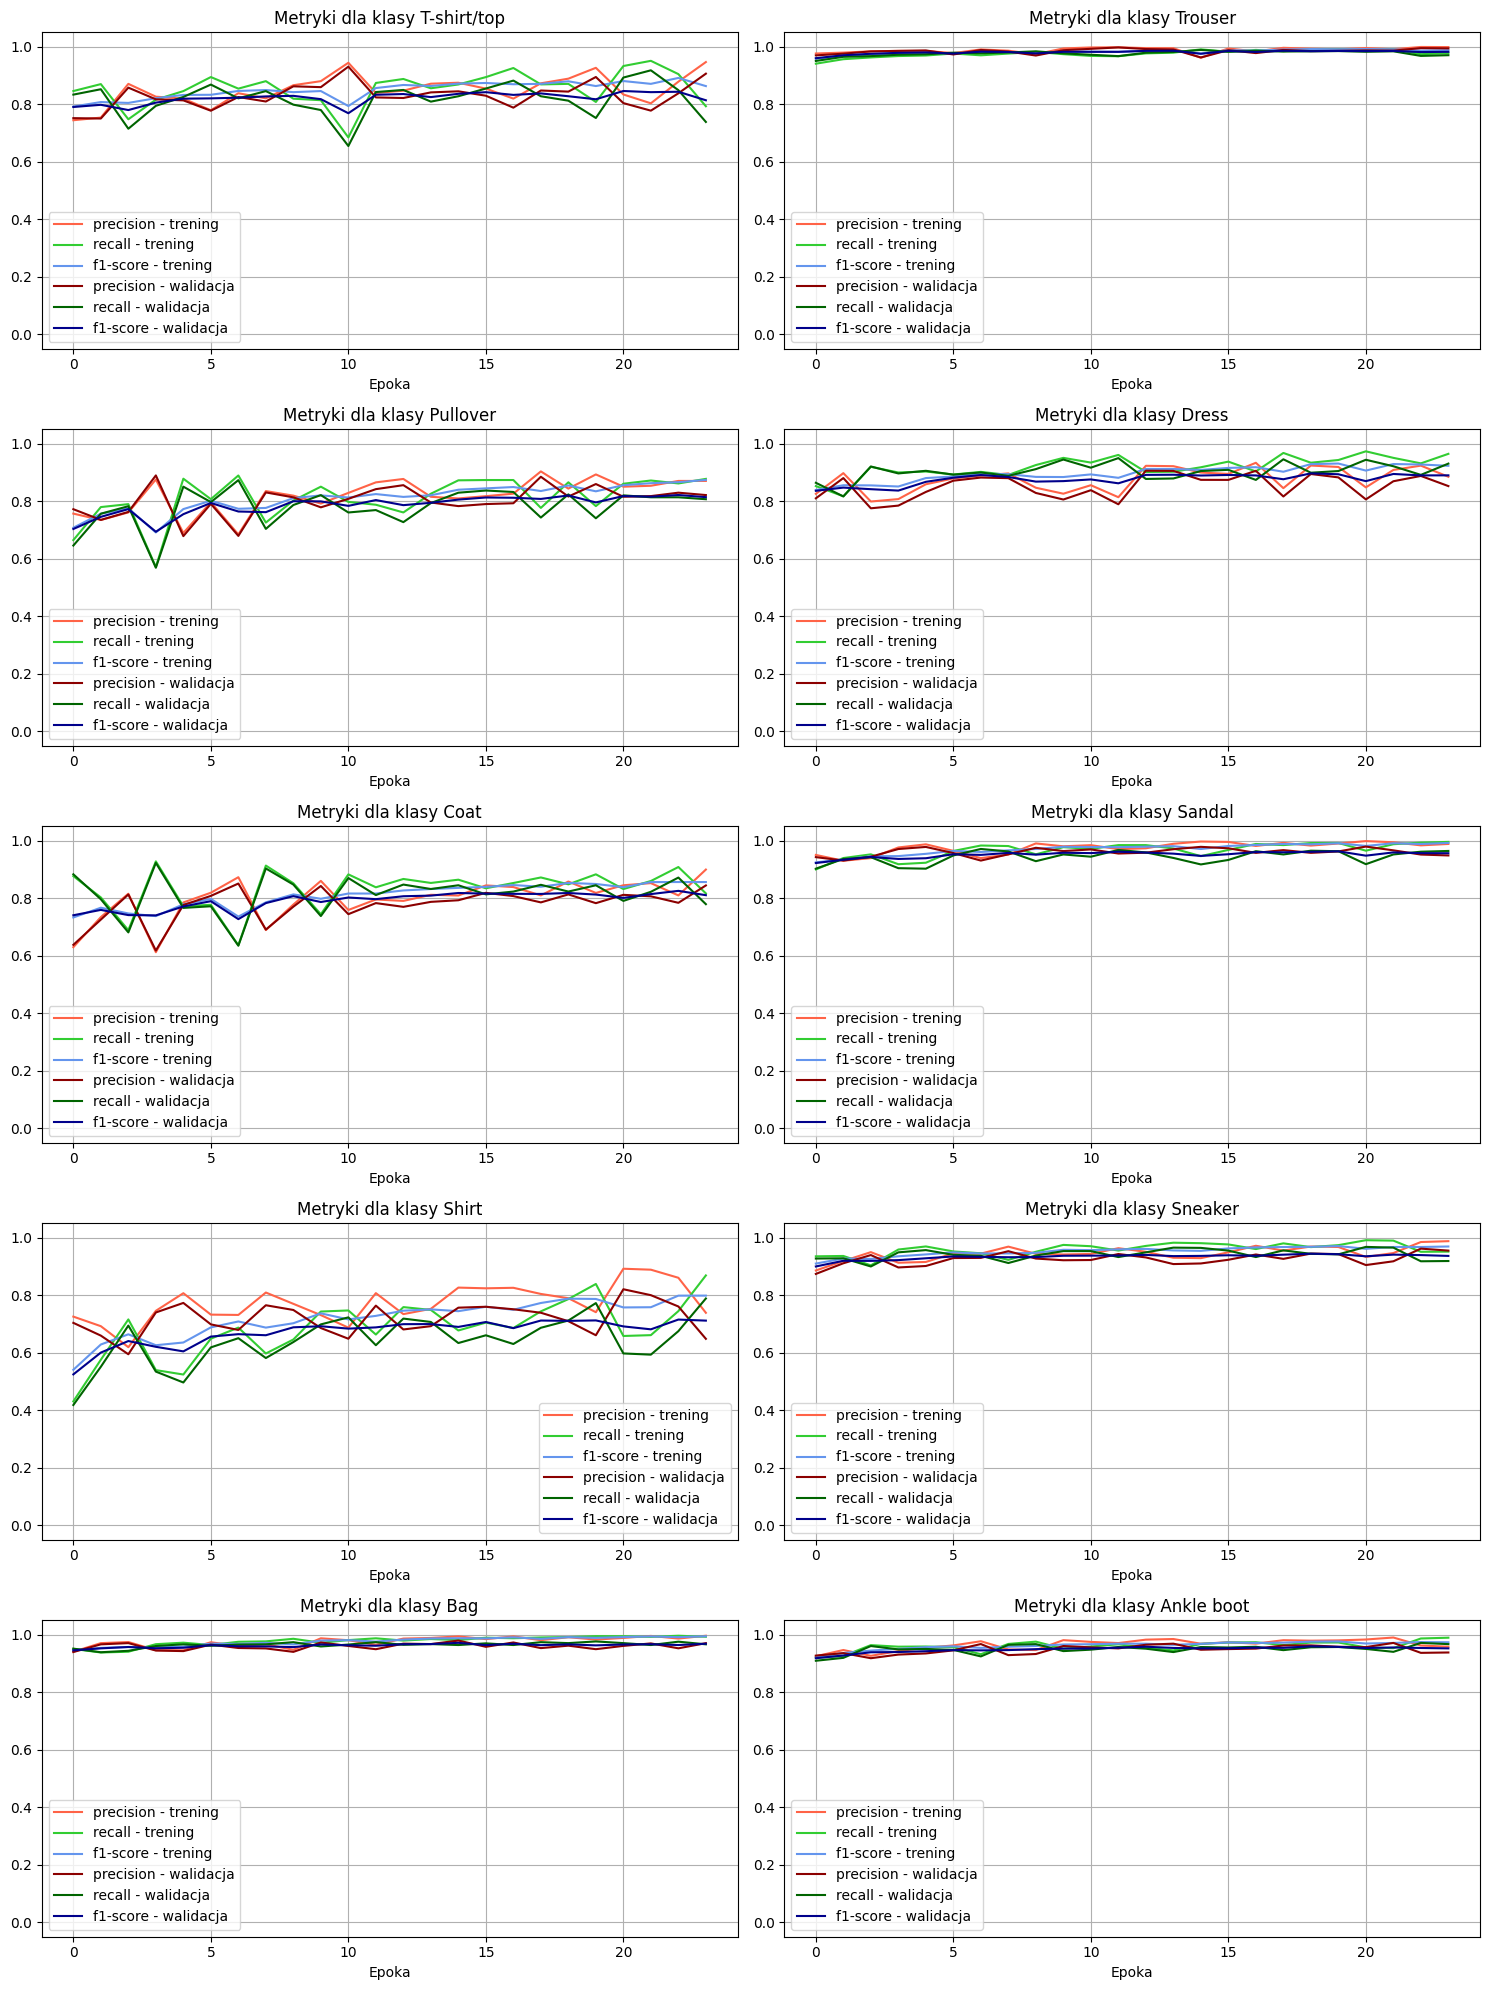

In [ ]:
# larger architecture
mlp = ParametrizedMLP([100, 50, 25])
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters()), early_stopping=True)
tr_losses3, val_losses3, tr_metrics3, val_metrics3, tr_accuracies3, val_accuracies3 = trainer.training_loop(epochs_num, "larger-model")

create_loss_and_accuracy_plot(tr_losses3, val_losses3, tr_accuracies3, val_accuracies3)
create_metrics_plot(tr_metrics3, val_metrics3)

Wizualizacja wag pokazuje, że zwiększenie architektury powiększa liczbę niewykorzystanych neuronów w pierwszej warstwie, co wskazywać może na brak potrzeby tak rozbudowanej sieci. W kolejnych eksperymentach pozostane więc przy bazowej architekturze z warstwami [100, 50]

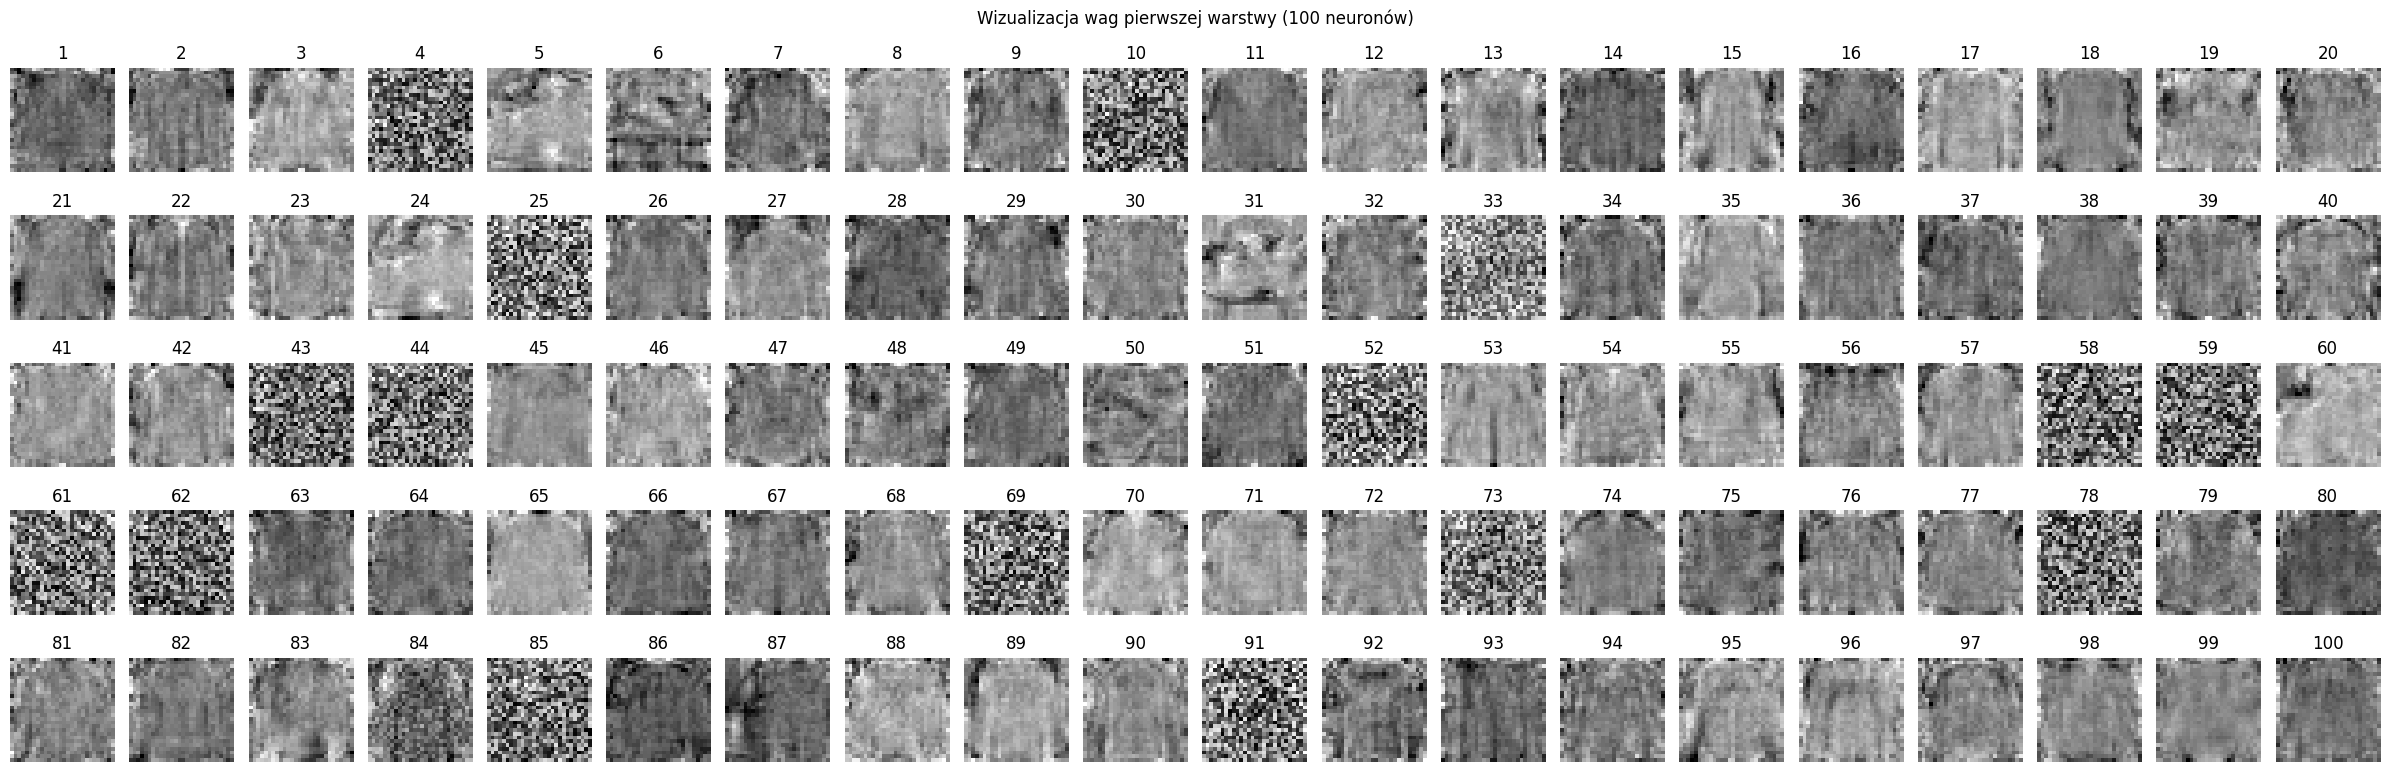

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50, 25])

weights_path = '/content/drive/MyDrive/mlp-models/larger-model_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Zastosowanie regularyzacji w zamierzeniu ma zapobiegać przeuczeniu się modelu poprzez uogólnienie uczonych zależności tzw. generalizację. Poniższe wyniki wykazują porównywalną stratę, lecz dokładność modelu z regularyzacją wzrosła o około 1%.

epoch: 1, train loss: 0.470, validation loss: 0.479
epoch: 2, train loss: 0.409, validation loss: 0.428
epoch: 3, train loss: 0.372, validation loss: 0.397
epoch: 4, train loss: 0.353, validation loss: 0.383
epoch: 5, train loss: 0.339, validation loss: 0.374
epoch: 10, train loss: 0.276, validation loss: 0.332
epoch: 15, train loss: 0.247, validation loss: 0.326
epoch: 20, train loss: 0.221, validation loss: 0.323
epoch: 25, train loss: 0.211, validation loss: 0.337
Early stopping at epoch 26
test loss: 0.361


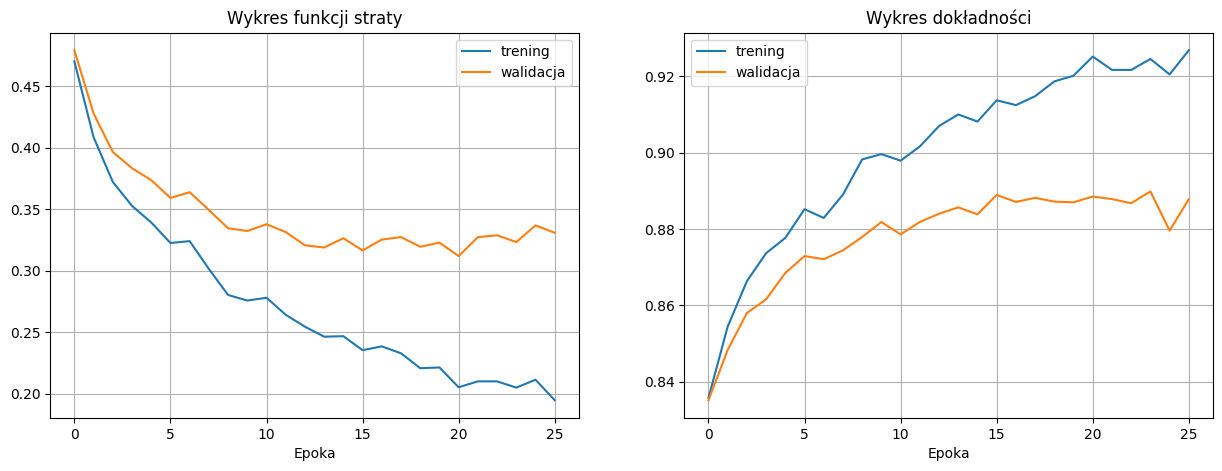

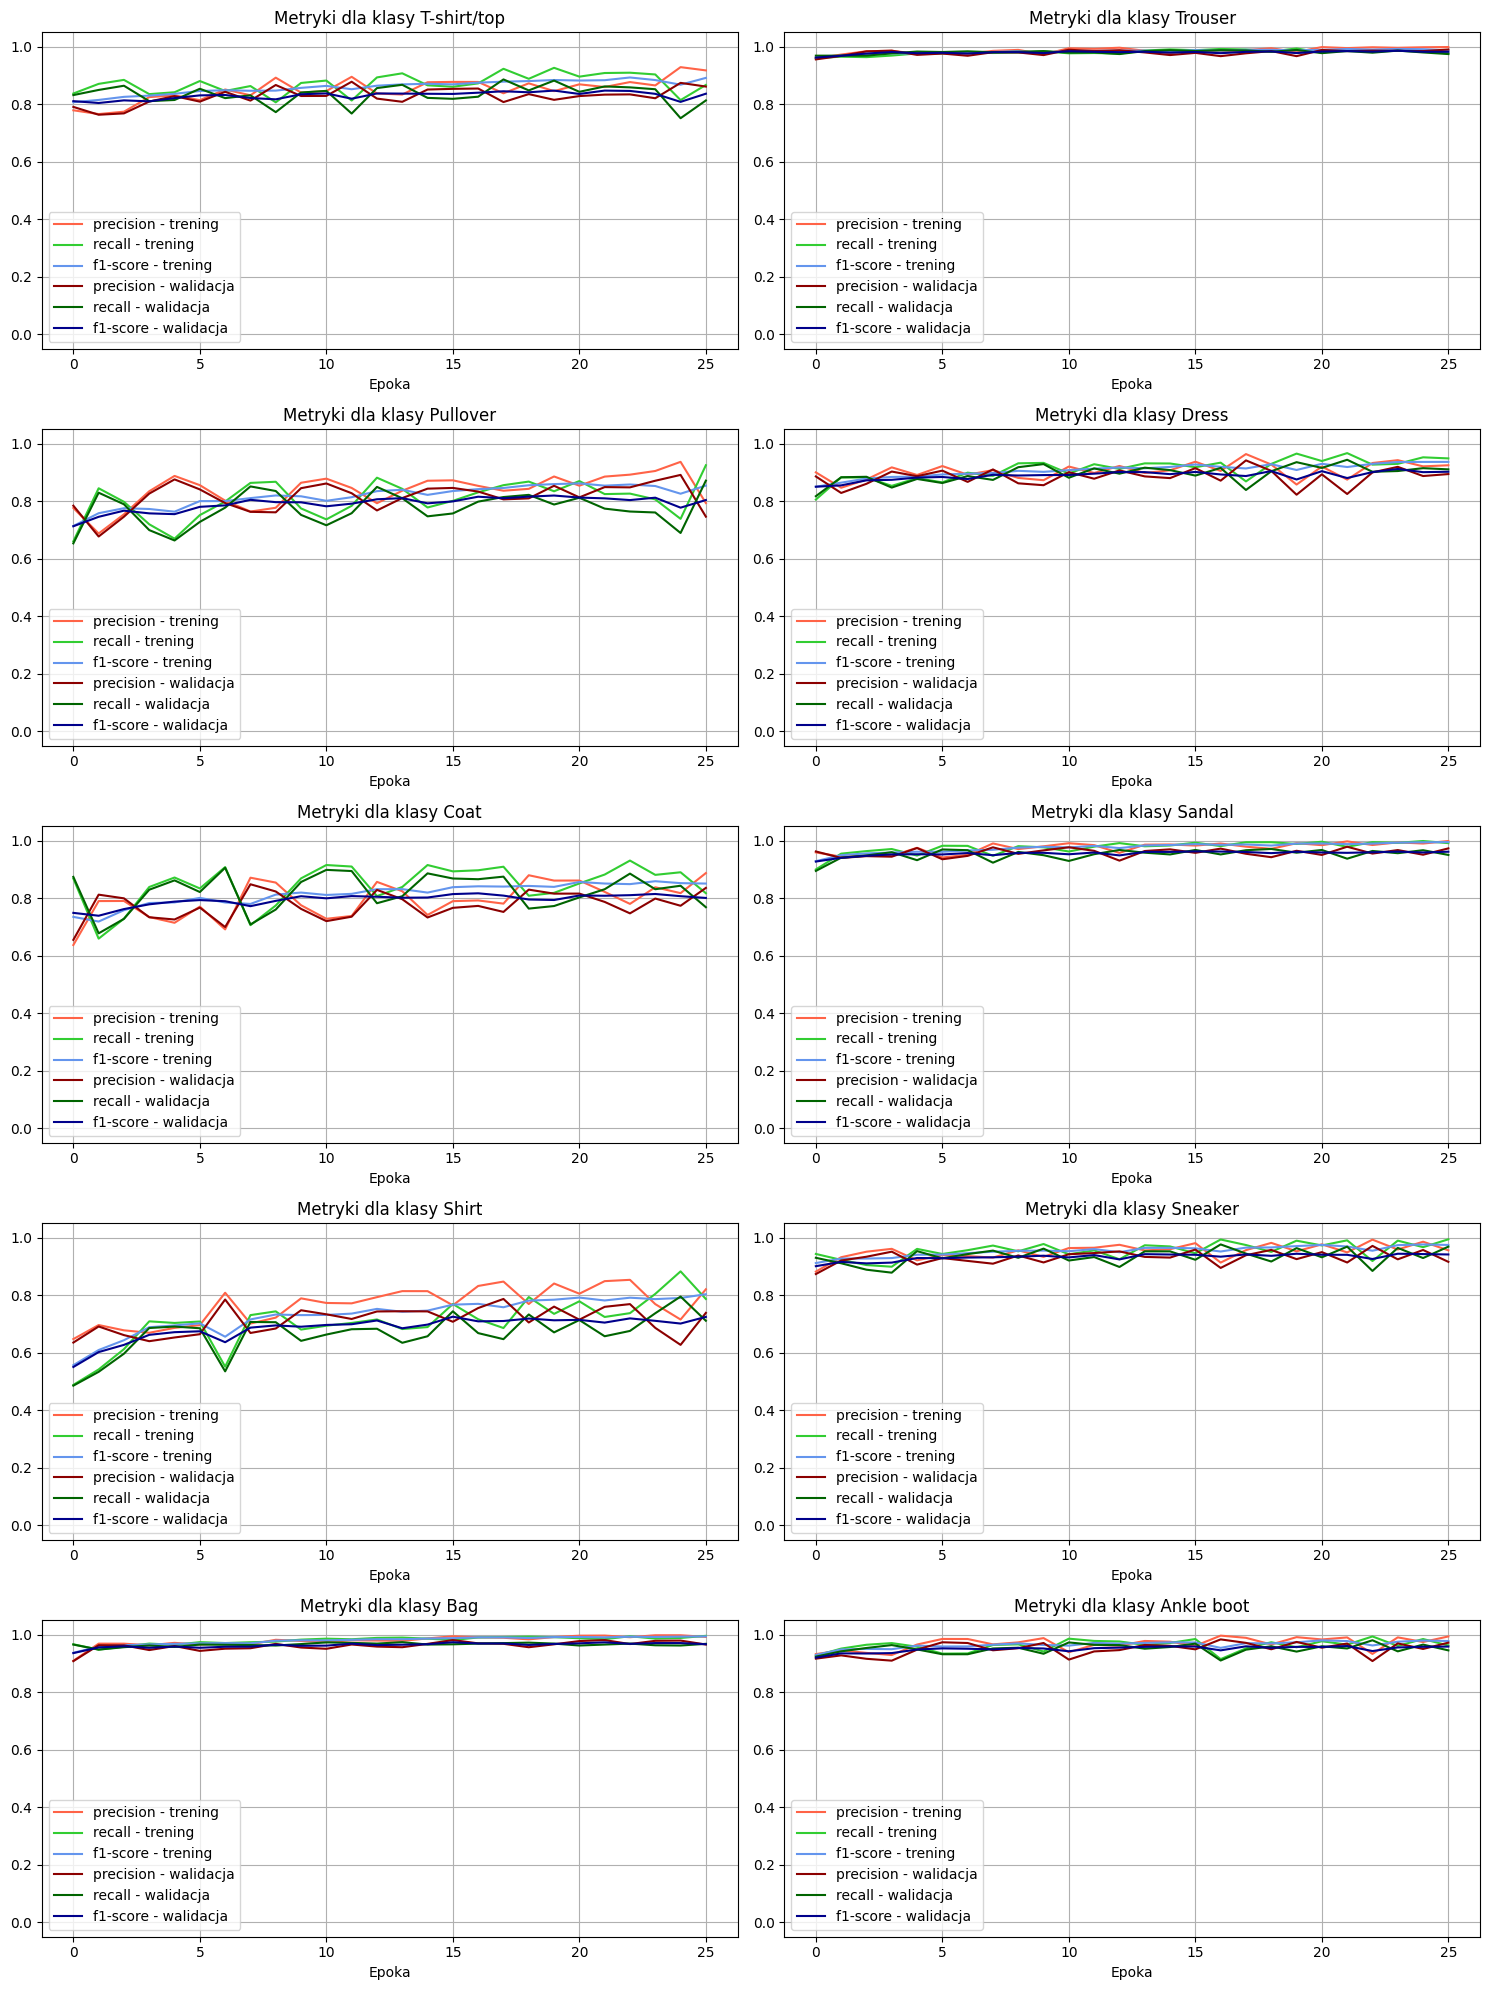

In [ ]:
# +l2 regularization (weight_decay)
mlp = ParametrizedMLP([100, 50])
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters(), weight_decay=0.0001), early_stopping=True)
tr_losses4, val_losses4, tr_metrics4, val_metrics4, tr_accuracies4, val_accuracies4 = trainer.training_loop(epochs_num, "model-l2")

create_loss_and_accuracy_plot(tr_losses4, val_losses4, tr_accuracies4, val_accuracies4)
create_metrics_plot(tr_metrics4, val_metrics4)

Najciekawsze dzieje się gdy zerknie się w wagi. Otóż regularyzacja zniwelowała występowanie zaszumionych neuronów oraz dodatkowo niektóre wykryły dość wyraźne wzorce. Wyniki te są obiecujące, lecz po sprawdzeniu na zbiorze testowym model ten nie różni się za bardzo od bazowego. Also, ciekawi mnie bardzo ten neuron 92, gdzie wszystkie inputy najwidoczniej są redukowane do minimum poza jednym losowym oznaczonym na biało xd ale nie wiem jak to wyjaśnić.

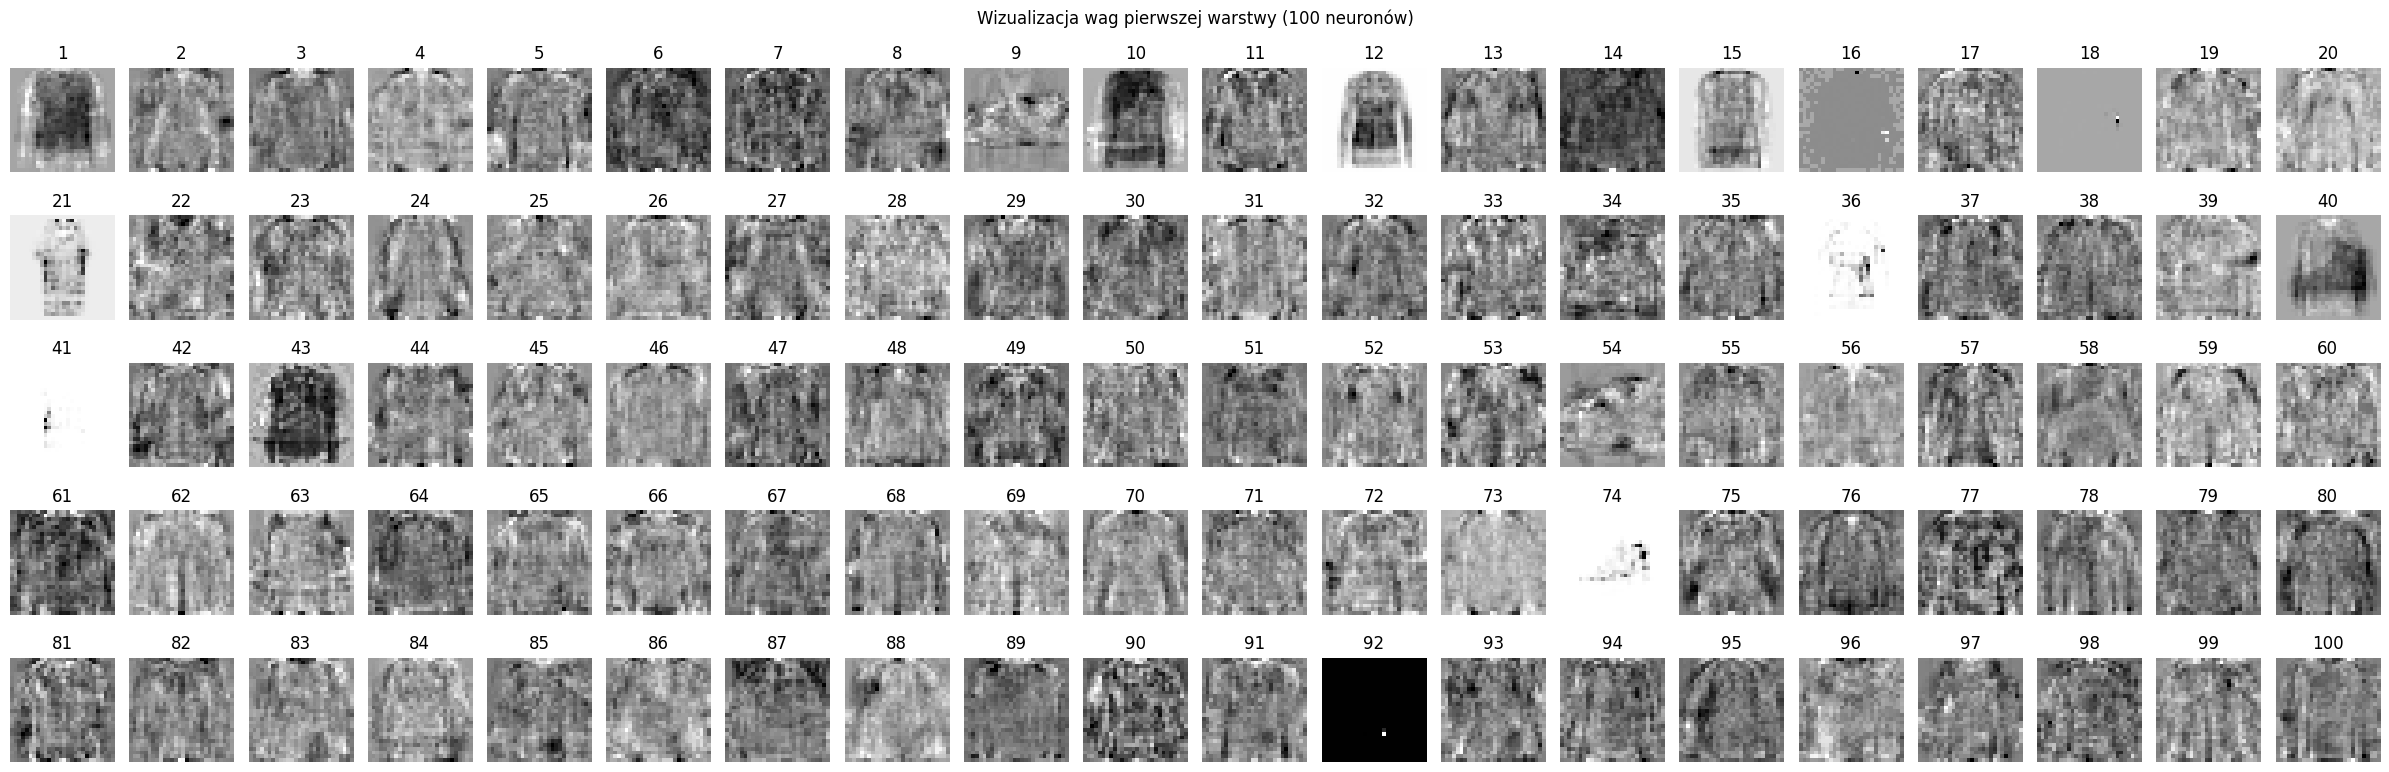

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50])

weights_path = '/content/drive/MyDrive/mlp-models/model-l2_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Kolejnym krokiem moich eksperymentów było sprawdzenie działania batch norm na model. Poniższe wizualizacje wskazują na nieznaczne pogorszenie wyników.

epoch: 1, train loss: 0.430, validation loss: 0.456
epoch: 2, train loss: 0.358, validation loss: 0.395
epoch: 3, train loss: 0.314, validation loss: 0.352
epoch: 4, train loss: 0.310, validation loss: 0.364
epoch: 5, train loss: 0.287, validation loss: 0.350
epoch: 10, train loss: 0.248, validation loss: 0.342
Early stopping at epoch 13
test loss: 0.369


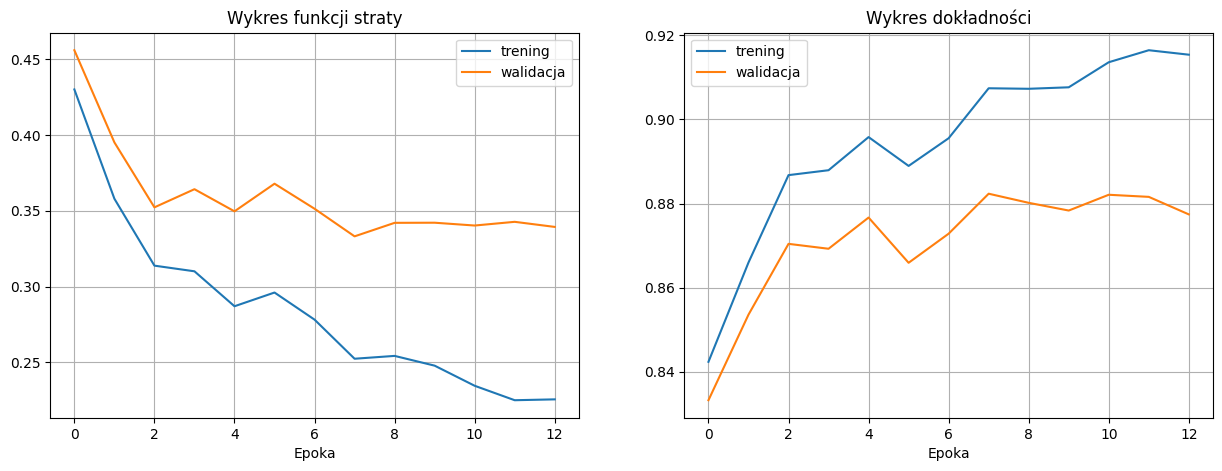

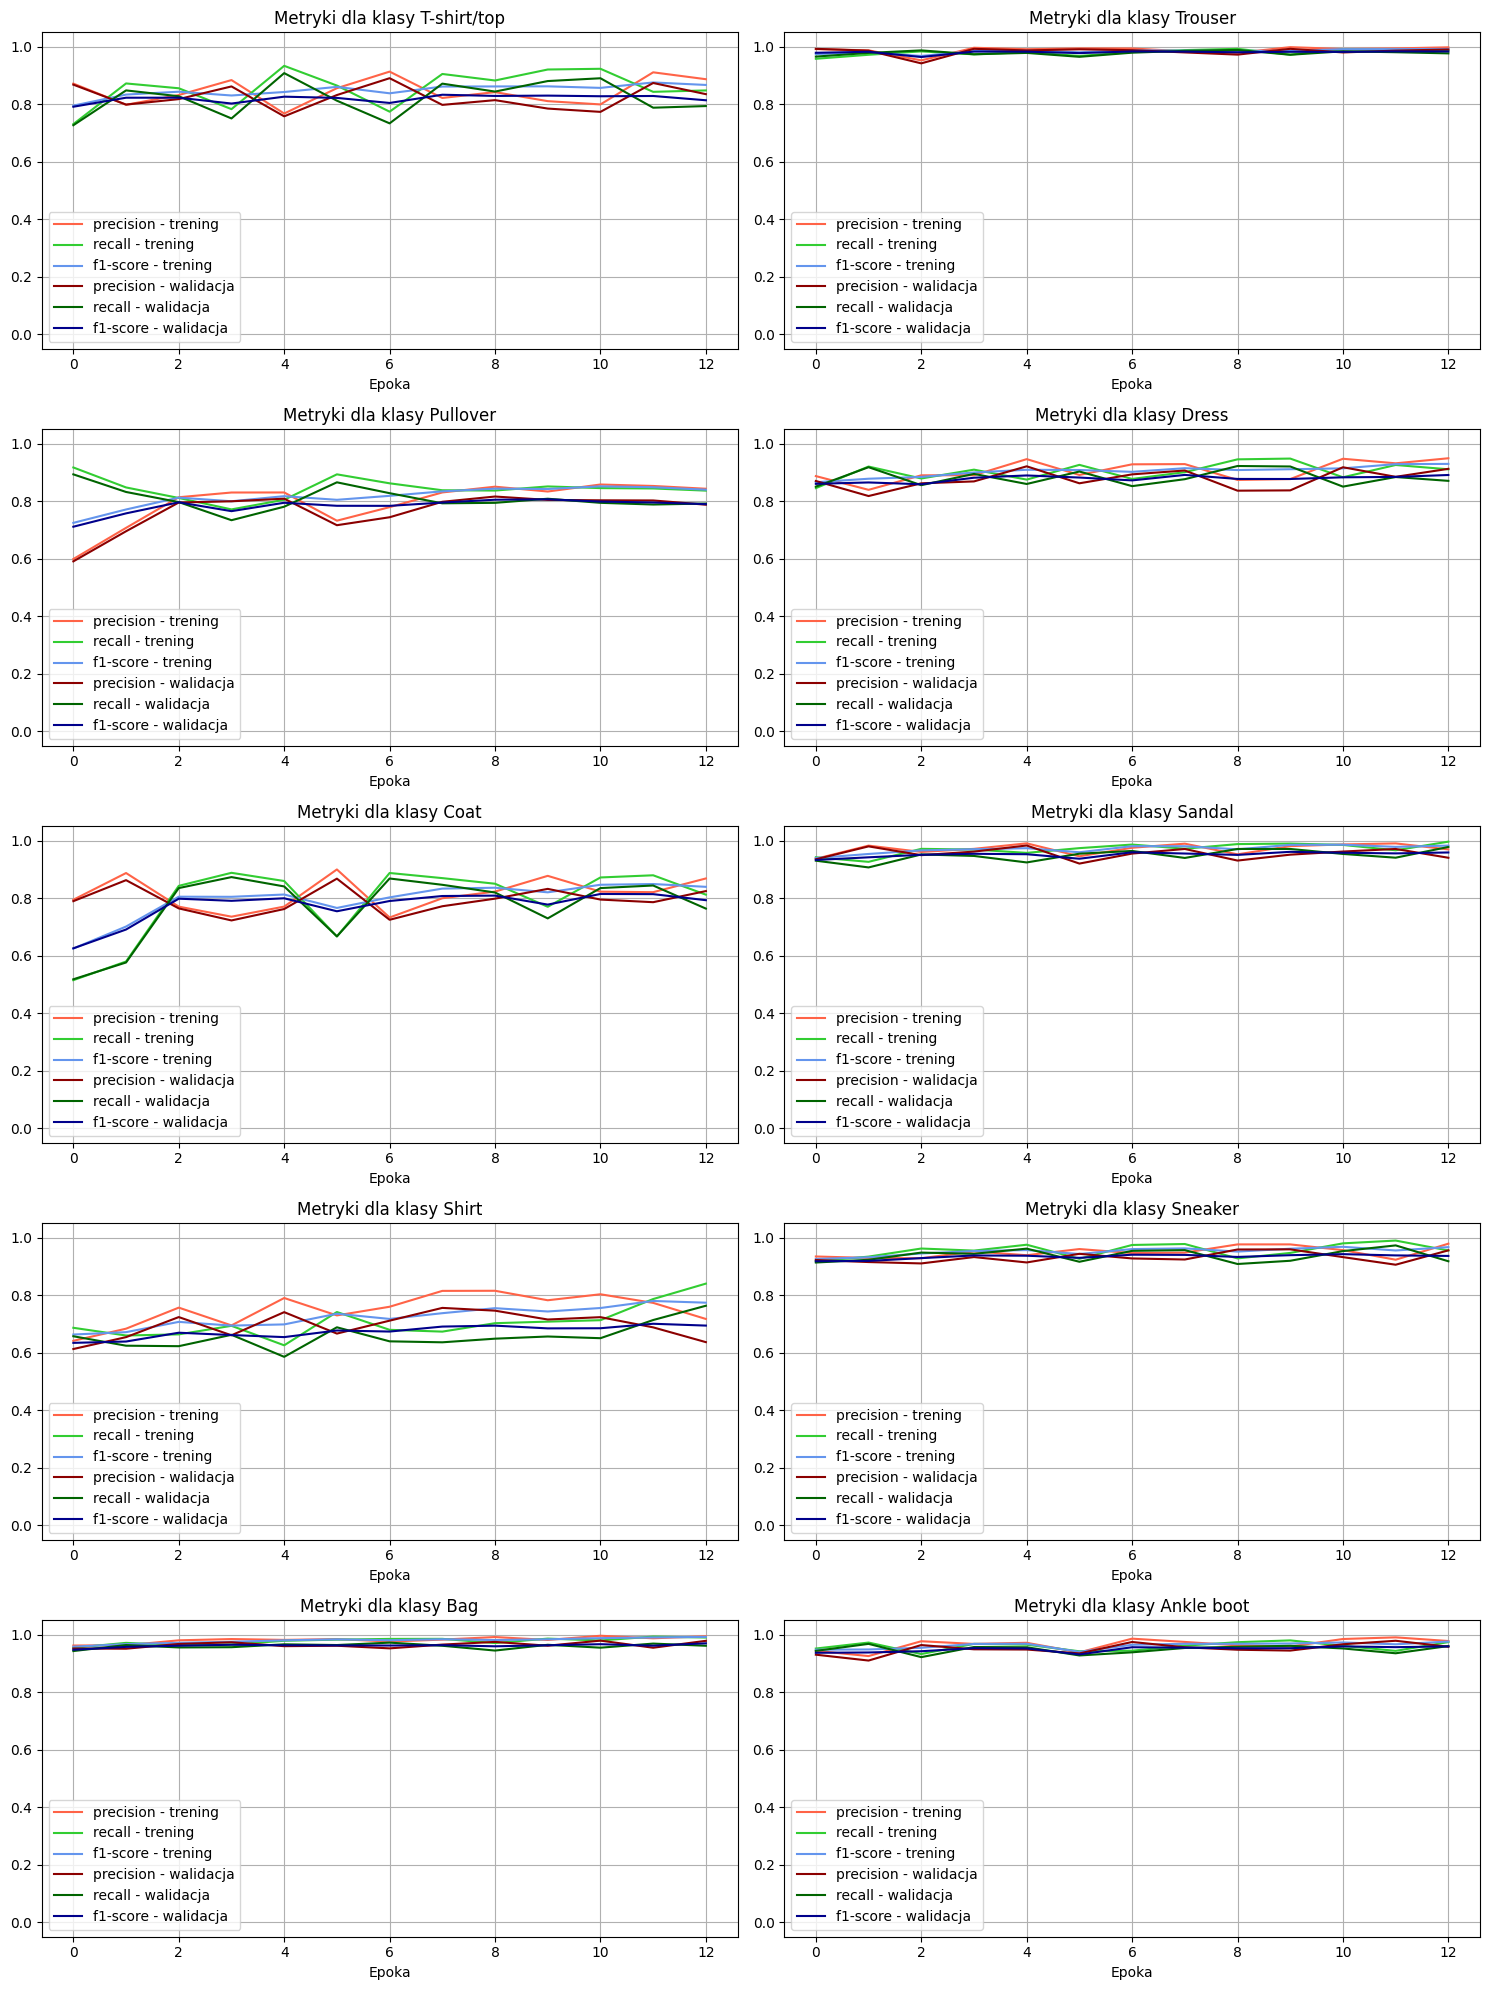

In [ ]:
# +batch norm
mlp = ParametrizedMLP([100, 50], batch_norm=True)
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters(), weight_decay=0.0001), early_stopping=True)
tr_losses5, val_losses5, tr_metrics5, val_metrics5, tr_accuracies5, val_accuracies5 = trainer.training_loop(epochs_num, "model-batch-norm")

create_loss_and_accuracy_plot(tr_losses5, val_losses5, tr_accuracies5, val_accuracies5)
create_metrics_plot(tr_metrics5, val_metrics5)

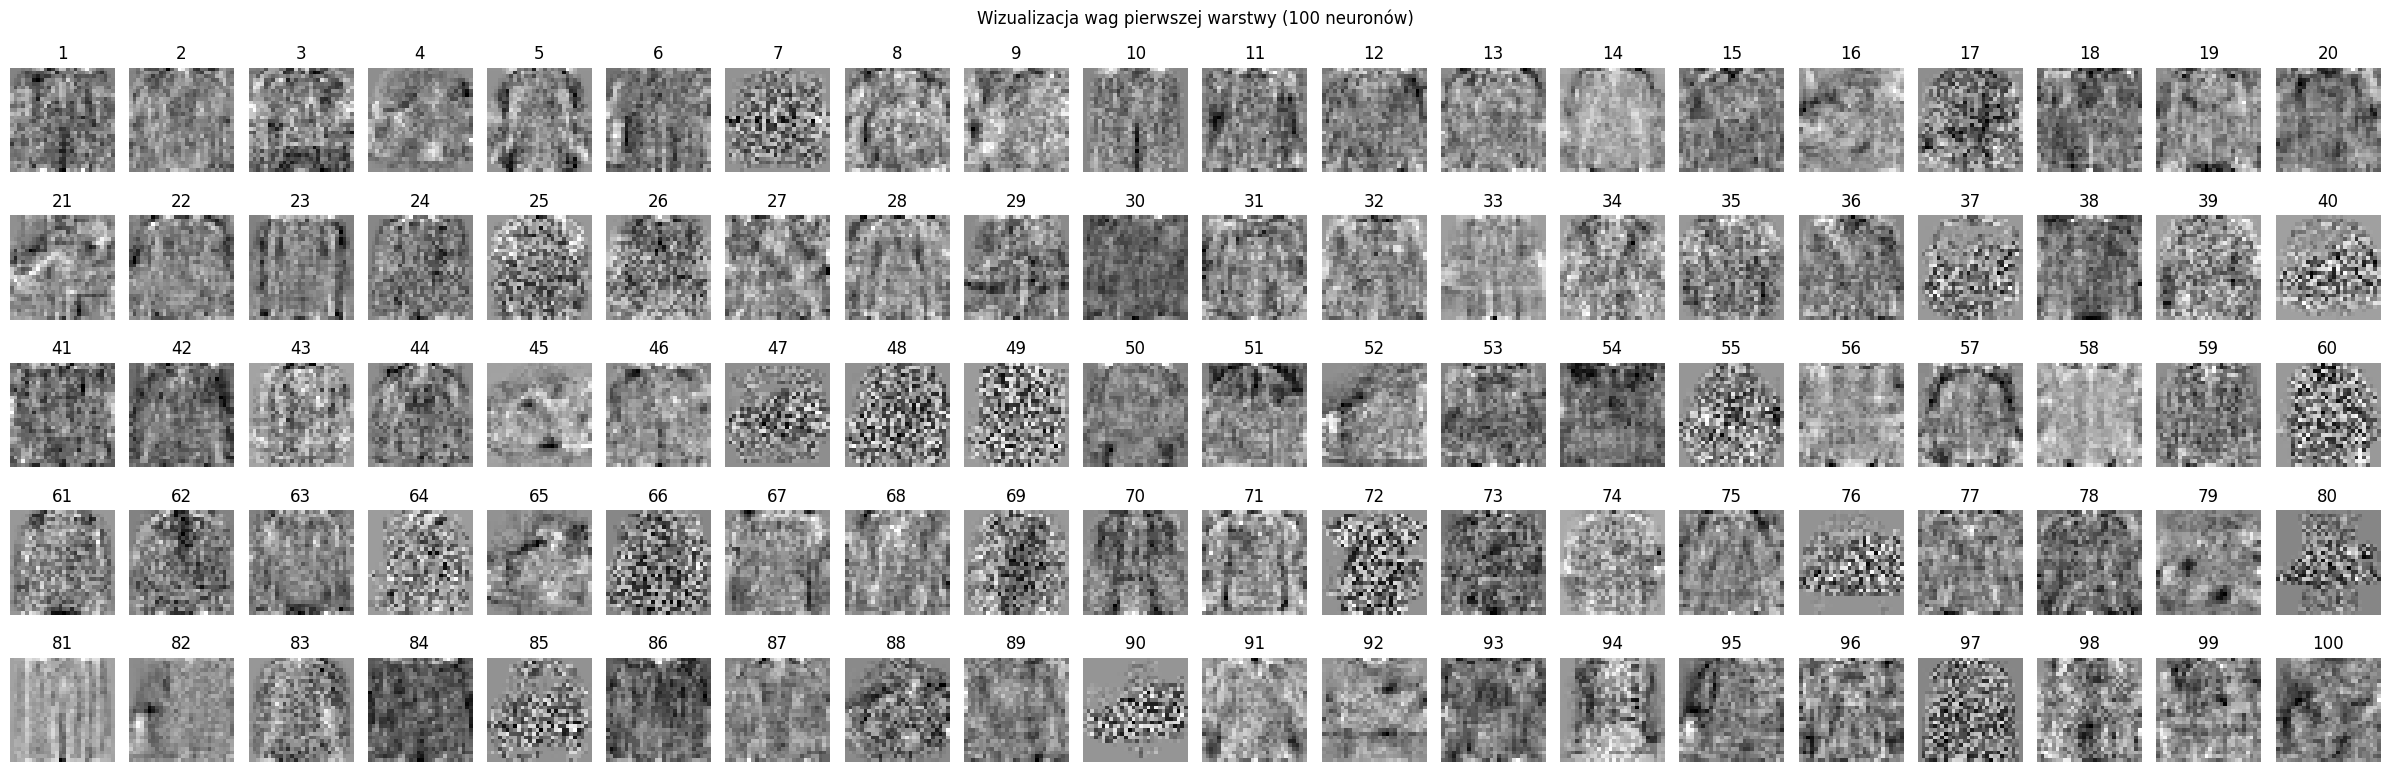

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50], batch_norm=True)

weights_path = '/content/drive/MyDrive/mlp-models/model-batch-norm_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

epoch: 1, train loss: 0.407, validation loss: 0.424
epoch: 2, train loss: 0.375, validation loss: 0.398
epoch: 3, train loss: 0.363, validation loss: 0.390
epoch: 4, train loss: 0.338, validation loss: 0.372
epoch: 5, train loss: 0.335, validation loss: 0.376
epoch: 10, train loss: 0.309, validation loss: 0.363
Early stopping at epoch 13
test loss: 0.367


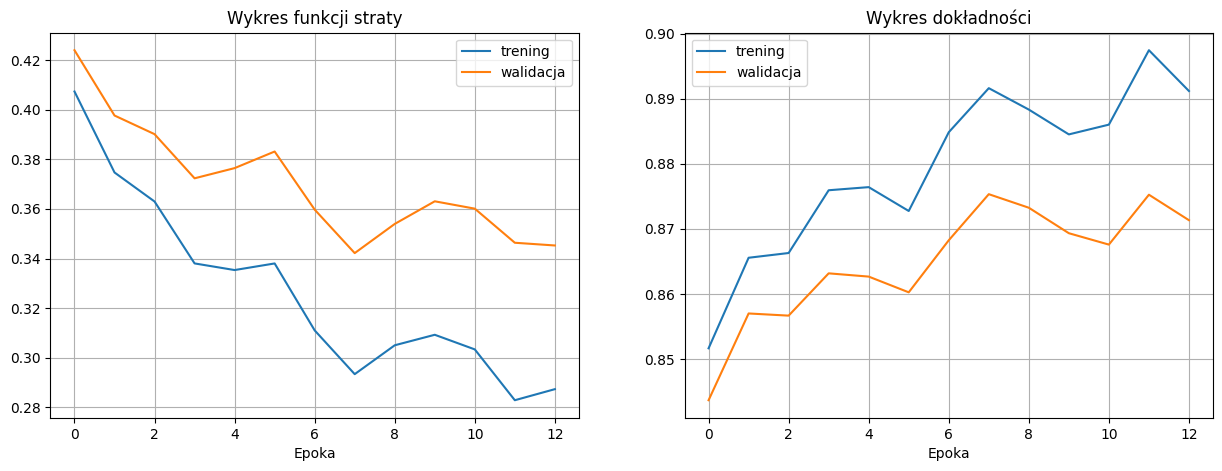

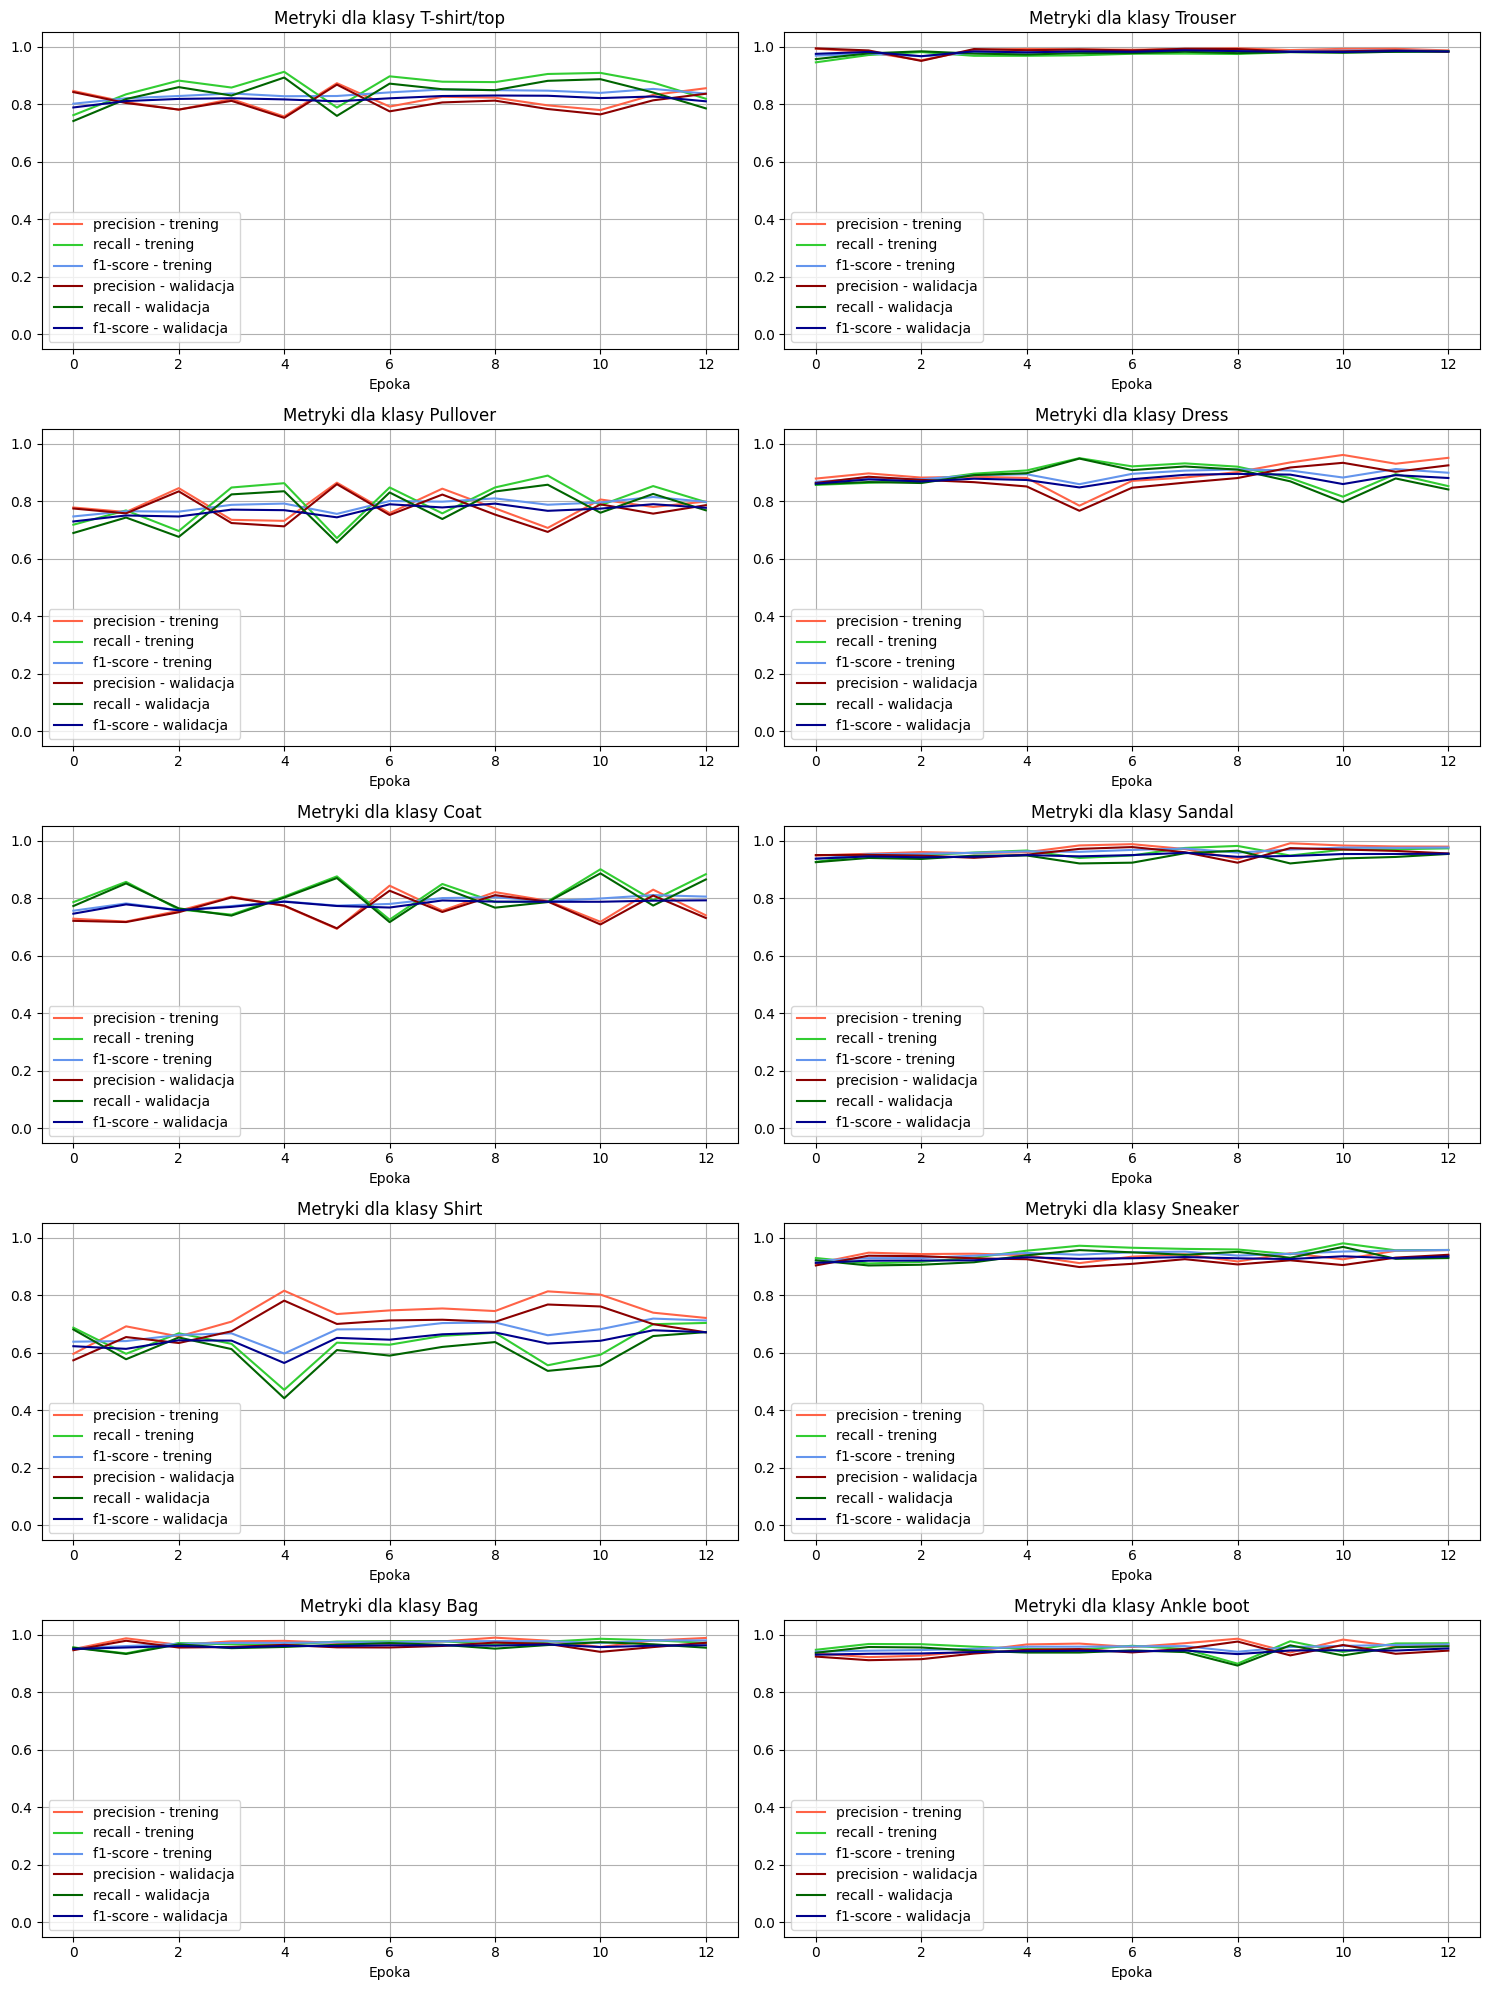

In [ ]:
# +25.0% dropout
mlp = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.Adam(mlp.parameters(), weight_decay=0.0001), early_stopping=True)
tr_losses6, val_losses6, tr_metrics6, val_metrics6, tr_accuracies6, val_accuracies6 = trainer.training_loop(epochs_num, "25-dropout")

create_loss_and_accuracy_plot(tr_losses6, val_losses6, tr_accuracies6, val_accuracies6)
create_metrics_plot(tr_metrics6, val_metrics6)

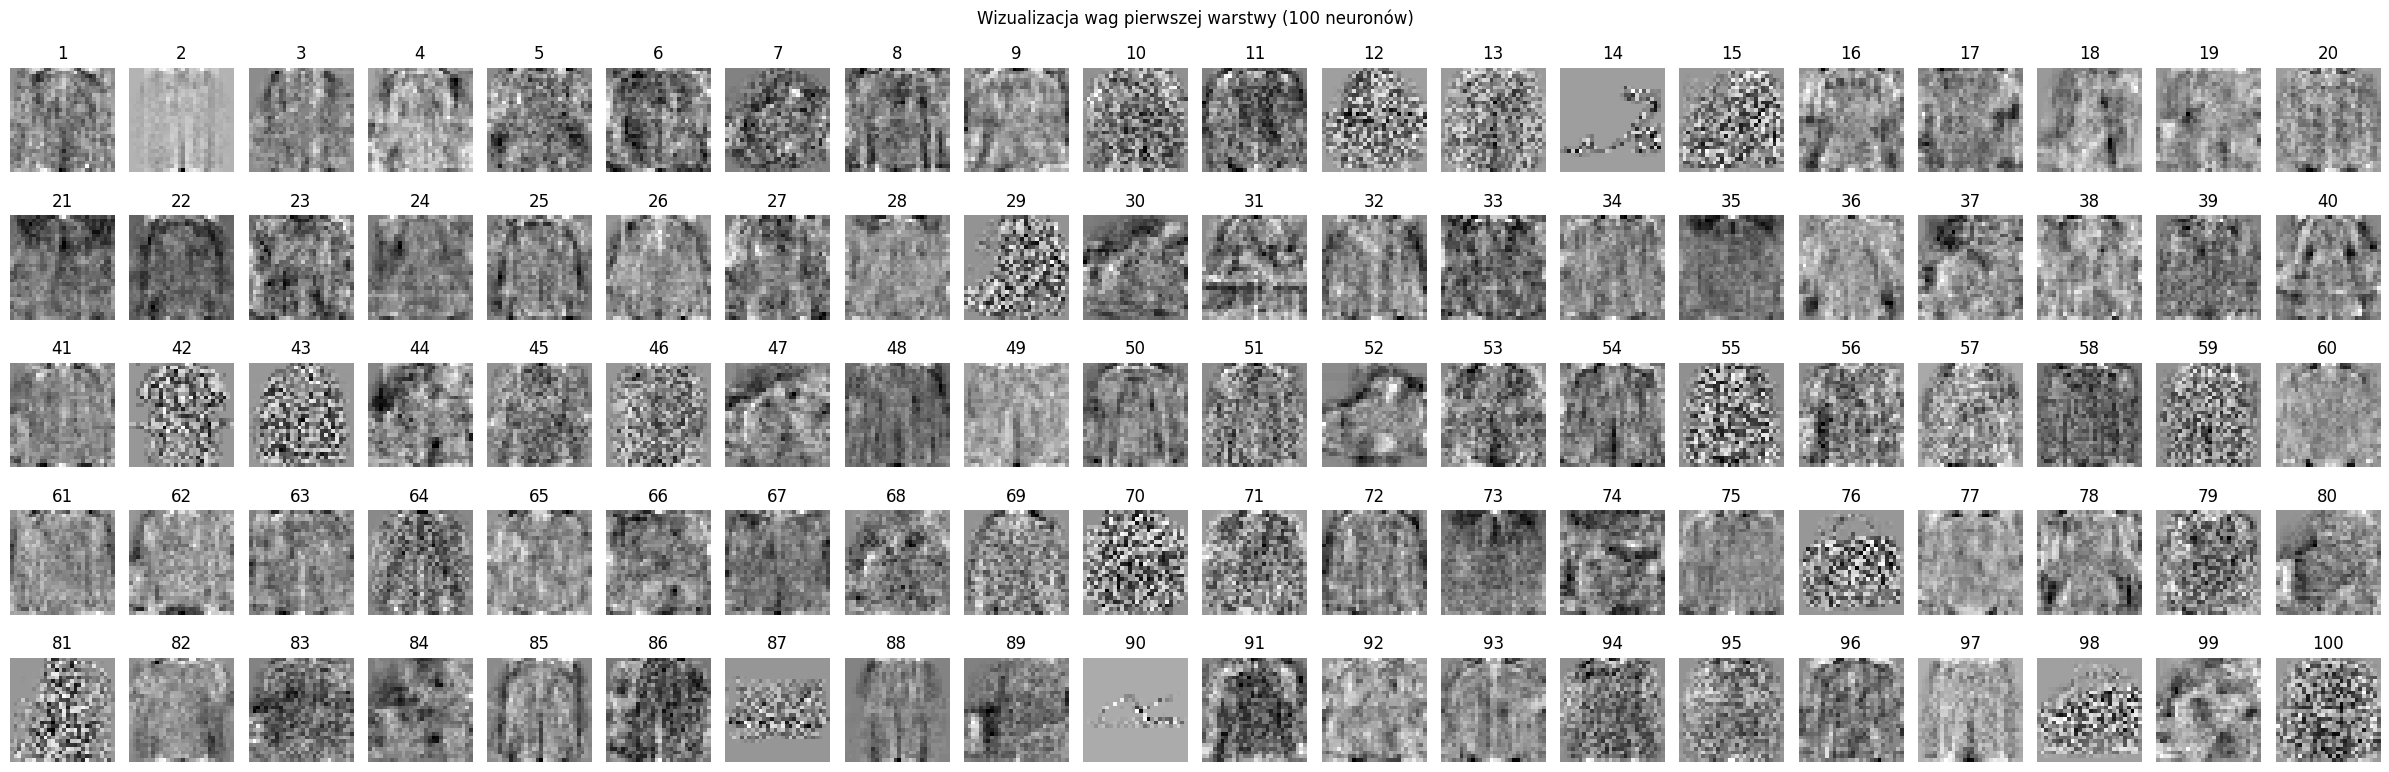

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)

weights_path = '/content/drive/MyDrive/mlp-models/25-dropout_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Do poprzedniego modelu dodałem optymalizator SGD zamiast Adama. Wizualizacje wskazują większą stratę, lecz wykresy metryk wskazują końcowo na podobną skuteczność modelu przy jednoczesnym stabilniejszym procesie uczenia. Warto zauważenia jest to, że trening nie zatrzymał się po early stopping, lecz po osiągniętej liczbie maksymalnej epok.

epoch: 1, train loss: 1.106, validation loss: 1.095
epoch: 2, train loss: 0.915, validation loss: 0.905
epoch: 3, train loss: 0.797, validation loss: 0.788
epoch: 4, train loss: 0.725, validation loss: 0.717
epoch: 5, train loss: 0.671, validation loss: 0.663
epoch: 10, train loss: 0.521, validation loss: 0.521
epoch: 15, train loss: 0.457, validation loss: 0.463
epoch: 20, train loss: 0.423, validation loss: 0.433
epoch: 25, train loss: 0.393, validation loss: 0.409
epoch: 30, train loss: 0.373, validation loss: 0.392
epoch: 35, train loss: 0.359, validation loss: 0.382
epoch: 40, train loss: 0.347, validation loss: 0.374
epoch: 45, train loss: 0.336, validation loss: 0.364
epoch: 50, train loss: 0.325, validation loss: 0.358
epoch: 55, train loss: 0.321, validation loss: 0.357
epoch: 60, train loss: 0.308, validation loss: 0.348
epoch: 65, train loss: 0.301, validation loss: 0.345
epoch: 70, train loss: 0.296, validation loss: 0.341
epoch: 75, train loss: 0.290, validation loss: 0.33

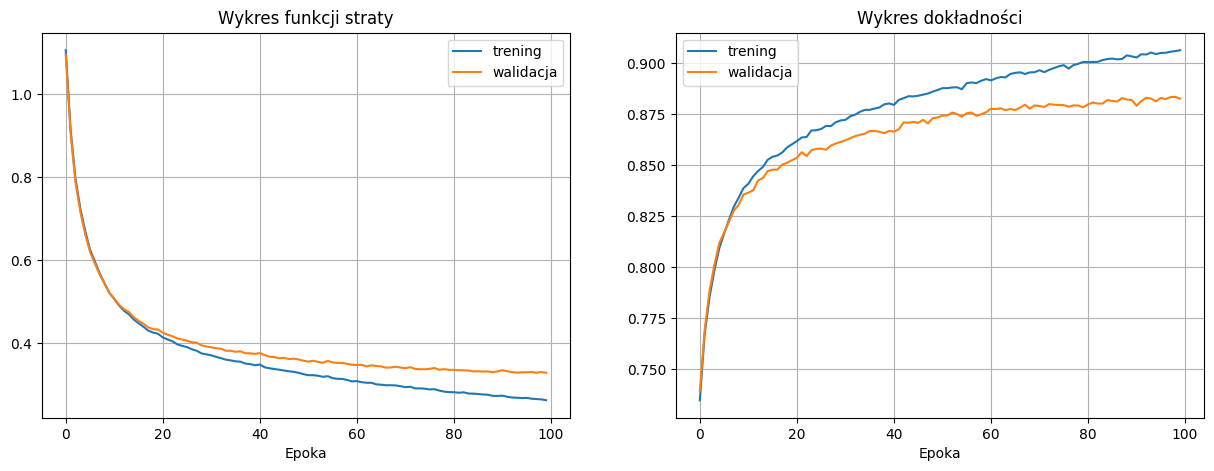

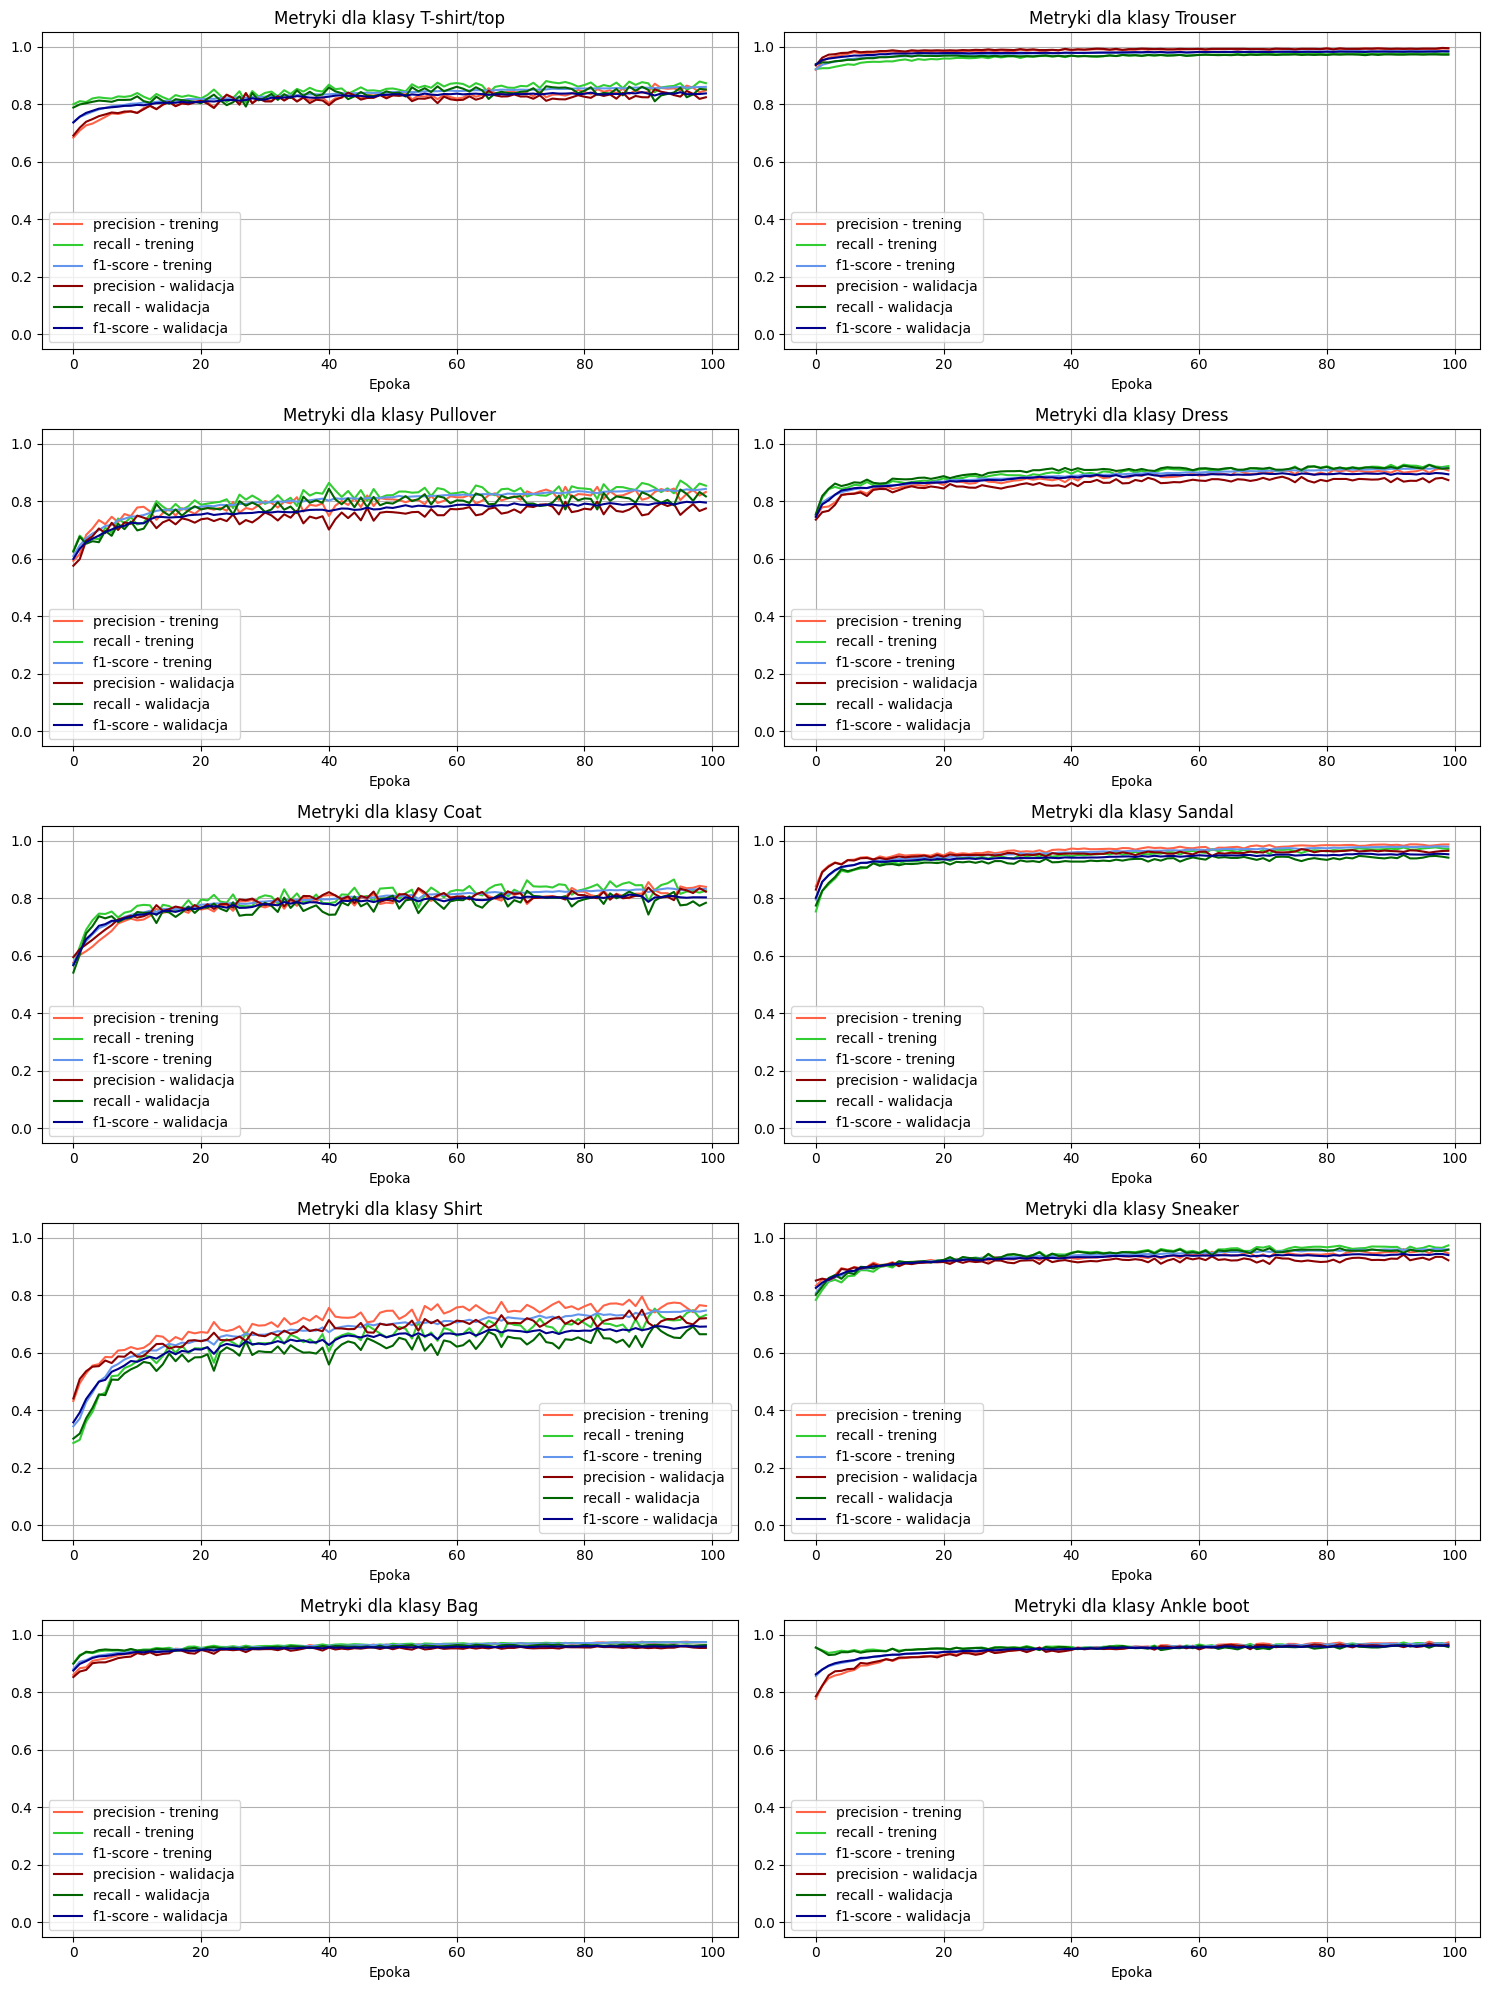

In [ ]:
# sgd
mlp = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)
trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), torch.optim.SGD(mlp.parameters(), weight_decay=0.0001), early_stopping=True)
tr_losses7, val_losses7, tr_metrics7, val_metrics7, tr_accuracies7, val_accuracies7 = trainer.training_loop(epochs_num, "model-sgd")

create_loss_and_accuracy_plot(tr_losses7, val_losses7, tr_accuracies7, val_accuracies7)
create_metrics_plot(tr_metrics7, val_metrics7)

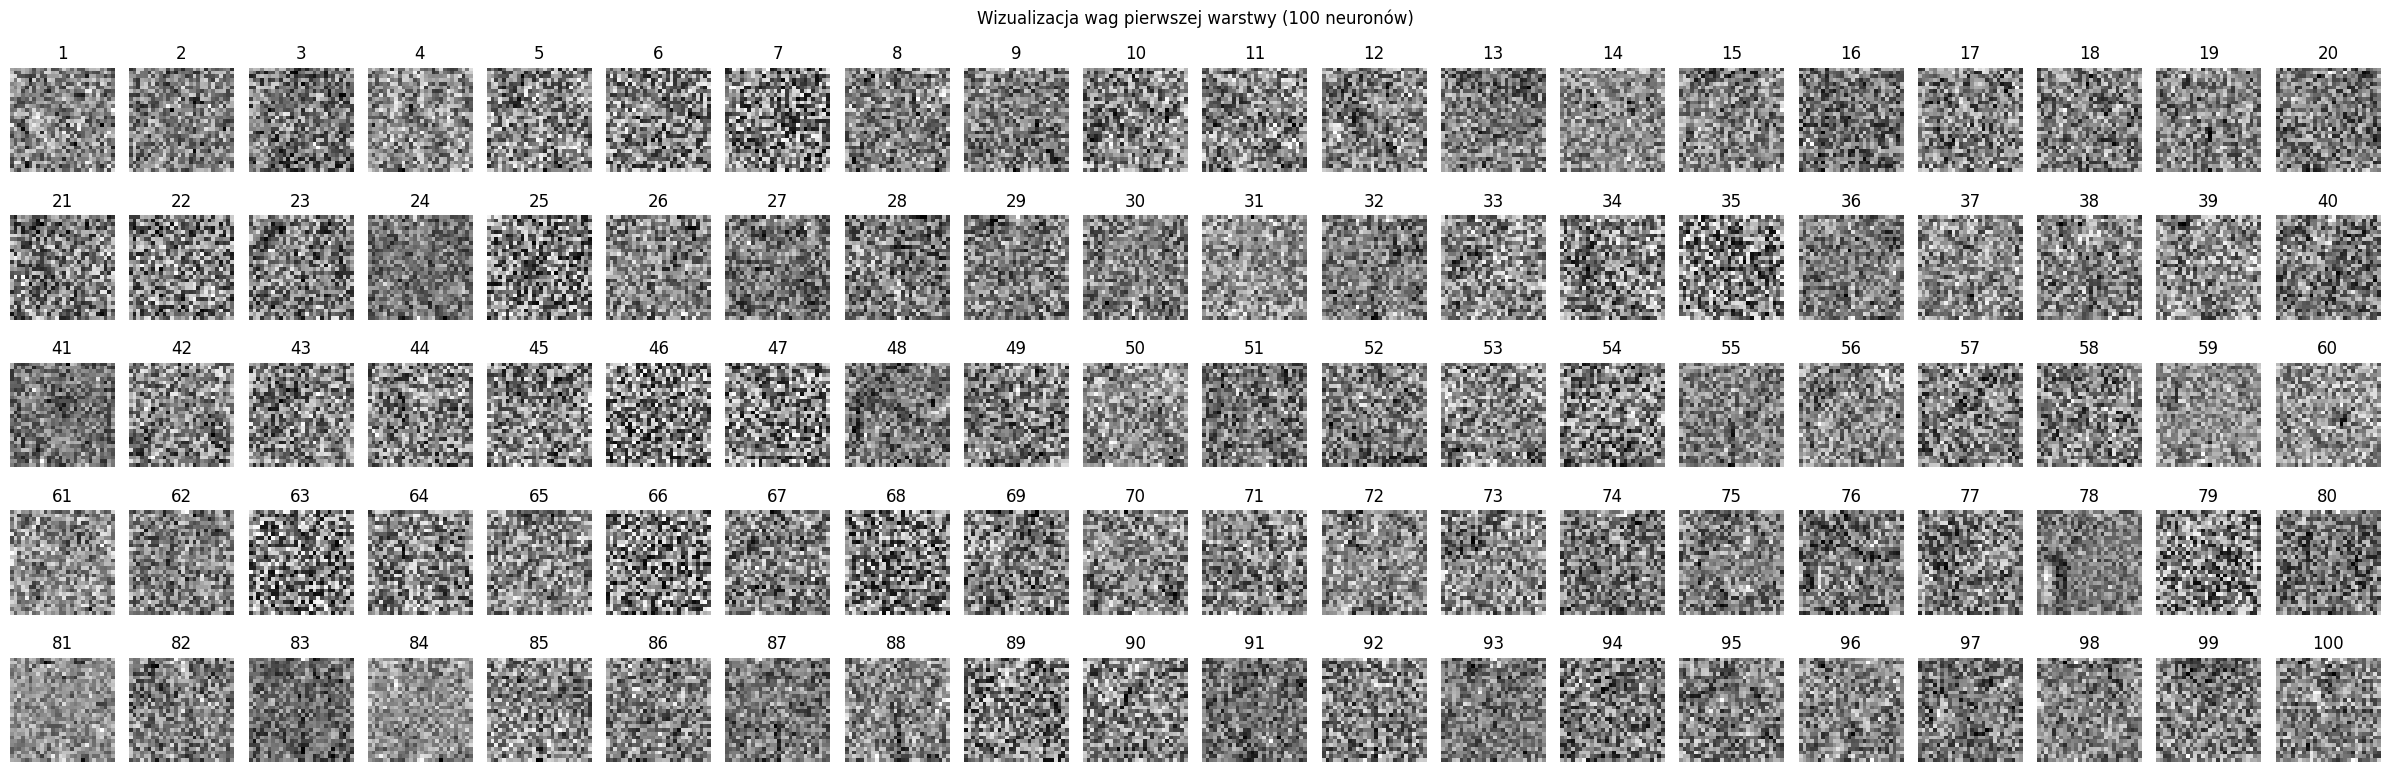

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)

weights_path = '/content/drive/MyDrive/mlp-models/model-sgd_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Poprzednie obserwacje skłoniły mnie do przetestowania schedulera właśnie na SGD. Intuicyjnie, początek treningu zostanie dpowiednio przyspieszony przy zachowaniu ostrożności w końcowej fazie. Na potrzeby tego eksperymentu zmieniłem liczbę epok.

In [ ]:
epochs_num = 70

Poniższe wizualizacje pokazują, że wykorzystanie schedulera istotnie zmniejszyło funkcję straty oraz jednocześnie skróciło prawie o połowę czas treningu.

LR: 0.0050
epoch: 1, train loss: 0.673, validation loss: 0.665
LR: 0.0050
epoch: 2, train loss: 0.529, validation loss: 0.527
LR: 0.0050
epoch: 3, train loss: 0.470, validation loss: 0.473
LR: 0.0050
epoch: 4, train loss: 0.430, validation loss: 0.441
LR: 0.0049
epoch: 5, train loss: 0.407, validation loss: 0.418
LR: 0.0049
LR: 0.0049
LR: 0.0049
LR: 0.0048
LR: 0.0048
epoch: 10, train loss: 0.341, validation loss: 0.369
LR: 0.0048
LR: 0.0047
LR: 0.0047
LR: 0.0046
LR: 0.0046
epoch: 15, train loss: 0.316, validation loss: 0.345
LR: 0.0045
LR: 0.0044
LR: 0.0044
LR: 0.0043
LR: 0.0042
epoch: 20, train loss: 0.295, validation loss: 0.343
LR: 0.0042
LR: 0.0041
LR: 0.0040
LR: 0.0039
LR: 0.0039
epoch: 25, train loss: 0.281, validation loss: 0.334
LR: 0.0038
LR: 0.0037
LR: 0.0036
LR: 0.0035
LR: 0.0034
epoch: 30, train loss: 0.265, validation loss: 0.328
LR: 0.0034
LR: 0.0033
LR: 0.0032
LR: 0.0031
LR: 0.0030
epoch: 35, train loss: 0.250, validation loss: 0.317
LR: 0.0029
LR: 0.0028
LR: 0.0027
LR: 

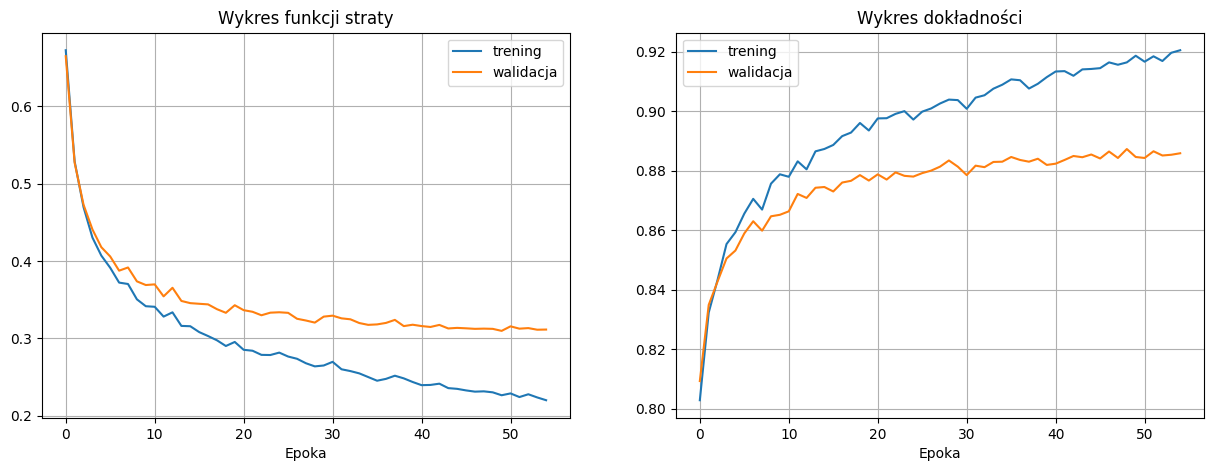

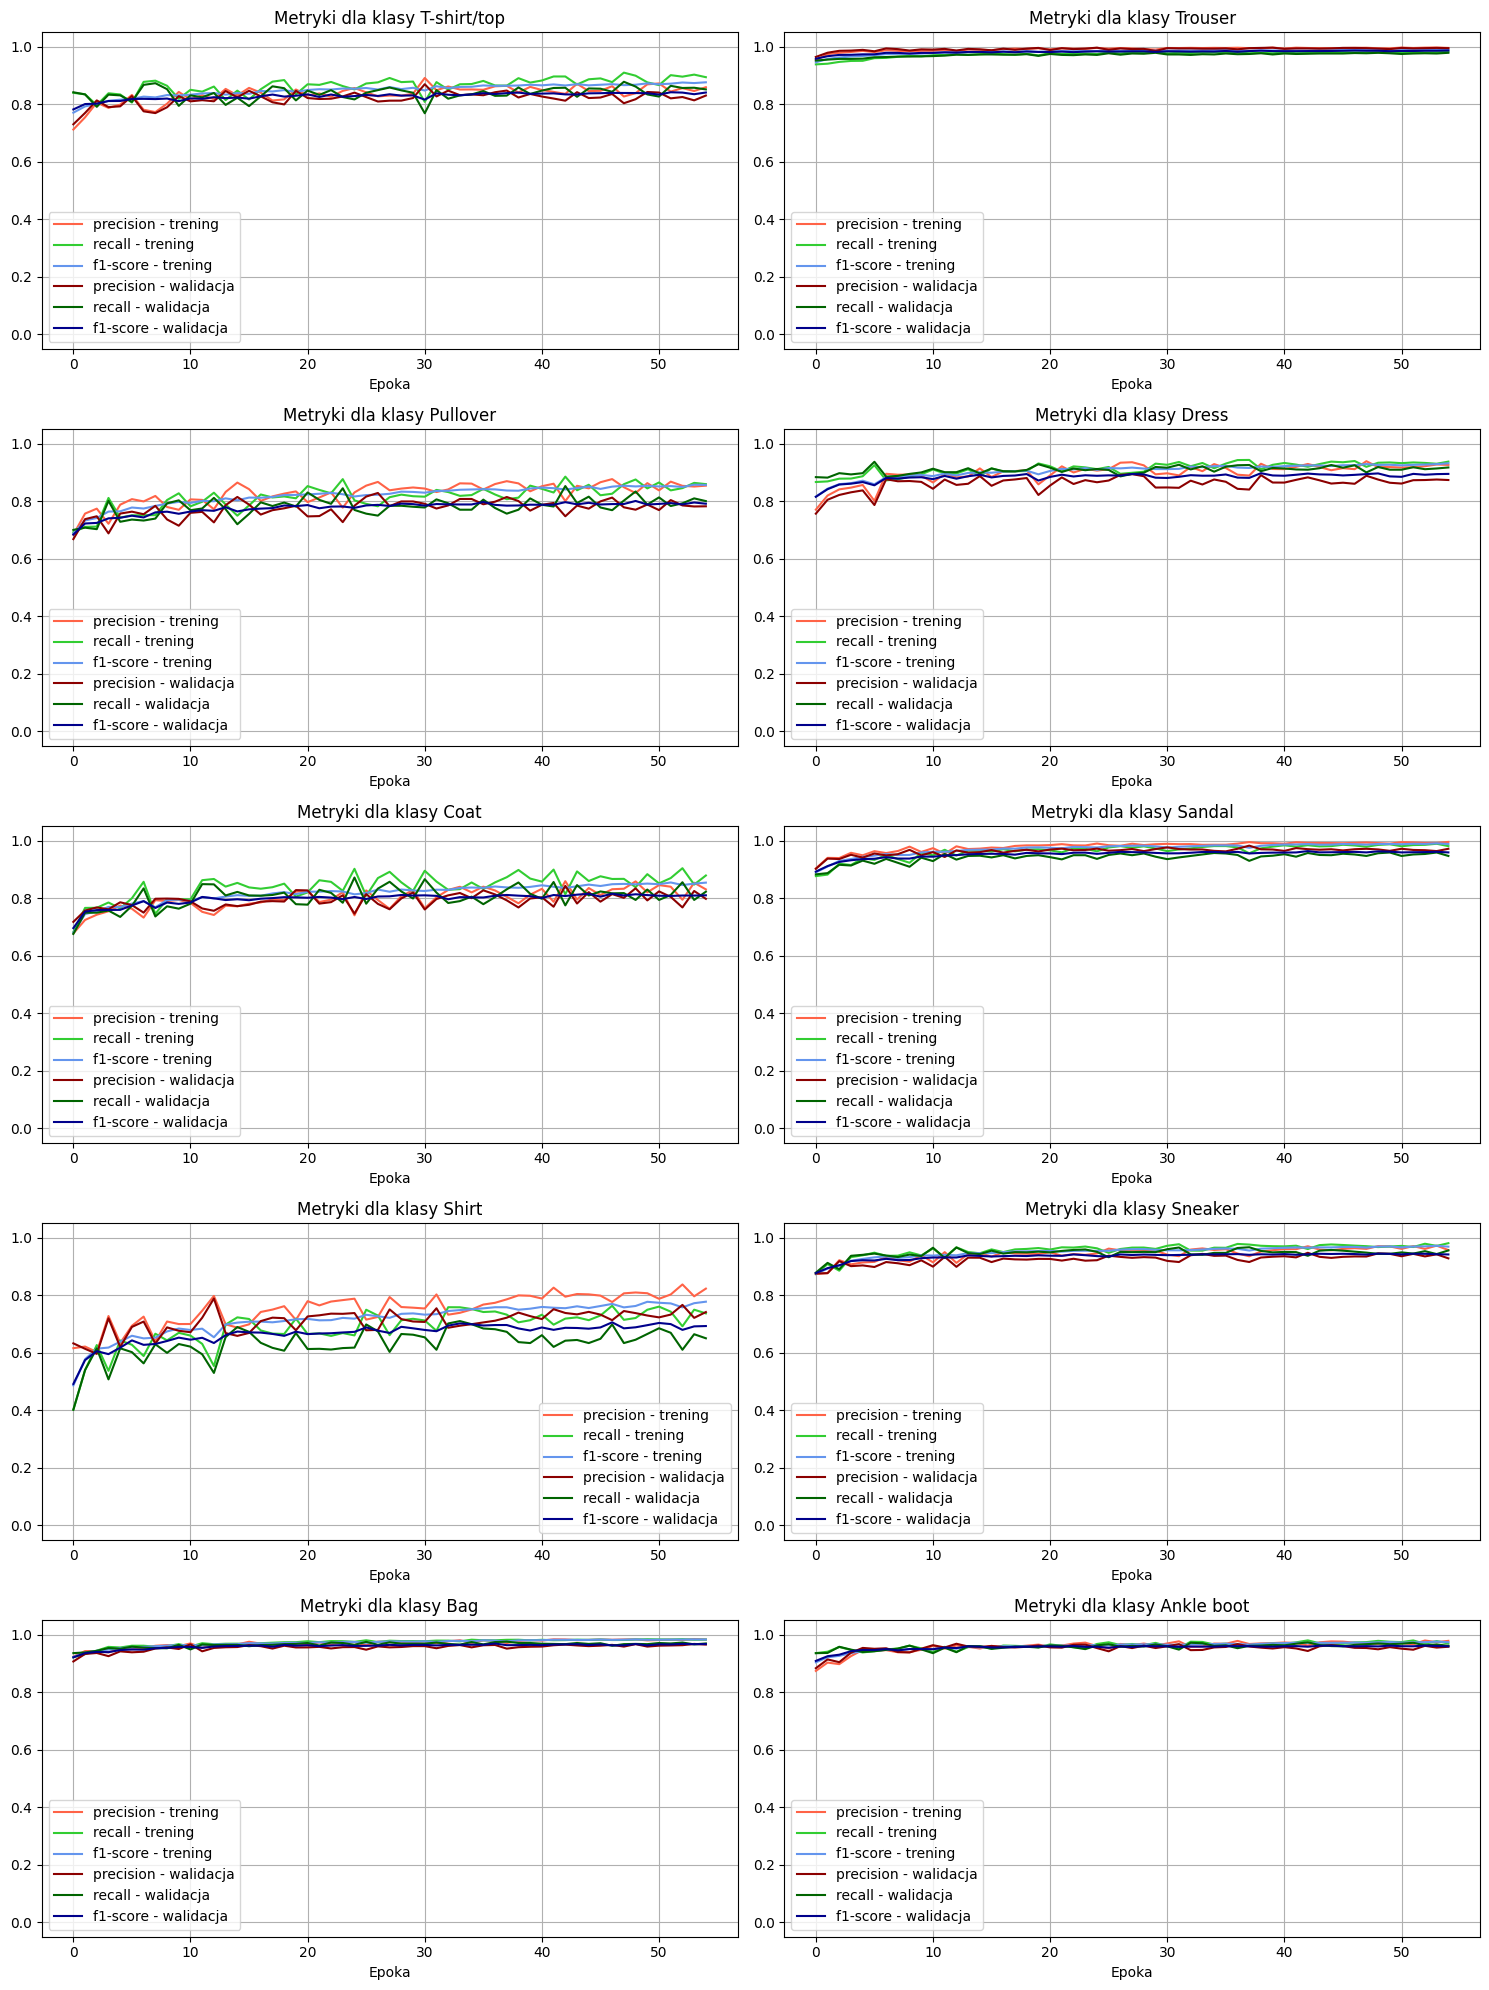

In [ ]:
# +scheduler
mlp = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)

optimizer = torch.optim.SGD(mlp.parameters(), lr=0.005, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num, eta_min=0.001)

trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler)
tr_losses8, val_losses8, tr_metrics8, val_metrics8, tr_accuracies8, val_accuracies8 = trainer.training_loop(epochs_num, "model-scheduled")

create_loss_and_accuracy_plot(tr_losses8, val_losses8, tr_accuracies8, val_accuracies8)
create_metrics_plot(tr_metrics8, val_metrics8)

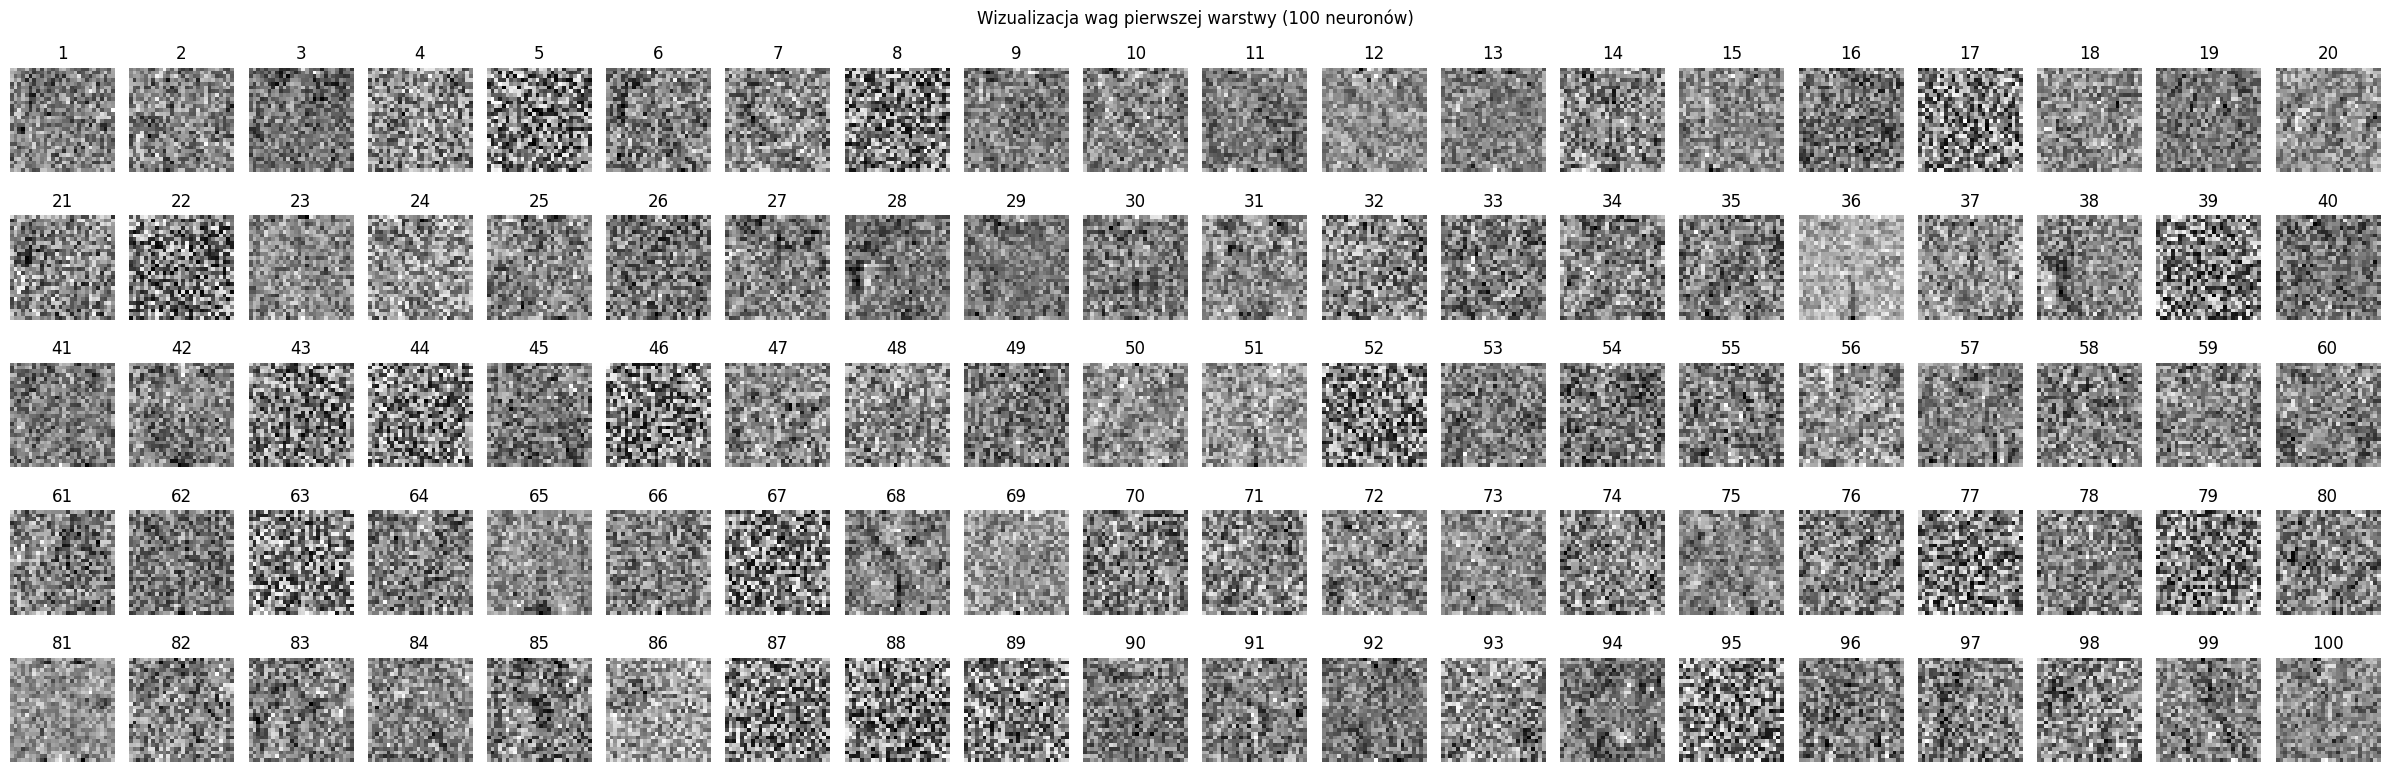

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)

weights_path = '/content/drive/MyDrive/mlp-models/model-scheduled_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

Zachęcony dobrymi wynikami modelu ze schedulerem, postanowiłem przetestować go jeszcze w połączeniu z Adamem.

In [ ]:
epochs_num = 60

Poniższe wizualizacje podobnie jak w przypadku modelu z SGD wykazują bardzo dobre (przynajmniej w porównaniu do reszty trenowanych modeli) wyniki.

LR: 0.0010
epoch: 1, train loss: 0.428, validation loss: 0.436
LR: 0.0010
epoch: 2, train loss: 0.387, validation loss: 0.400
LR: 0.0010
epoch: 3, train loss: 0.352, validation loss: 0.372
LR: 0.0010
epoch: 4, train loss: 0.344, validation loss: 0.366
LR: 0.0009
epoch: 5, train loss: 0.338, validation loss: 0.374
LR: 0.0009
LR: 0.0009
LR: 0.0009
LR: 0.0008
LR: 0.0008
epoch: 10, train loss: 0.293, validation loss: 0.346
LR: 0.0008
LR: 0.0007
LR: 0.0007
LR: 0.0006
LR: 0.0006
epoch: 15, train loss: 0.272, validation loss: 0.336
LR: 0.0006
LR: 0.0005
LR: 0.0005
LR: 0.0004
LR: 0.0004
epoch: 20, train loss: 0.256, validation loss: 0.324
LR: 0.0004
LR: 0.0003
LR: 0.0003
LR: 0.0003
LR: 0.0003
epoch: 25, train loss: 0.226, validation loss: 0.313
LR: 0.0002
LR: 0.0002
LR: 0.0002
Early stopping at epoch 28
test loss: 0.342


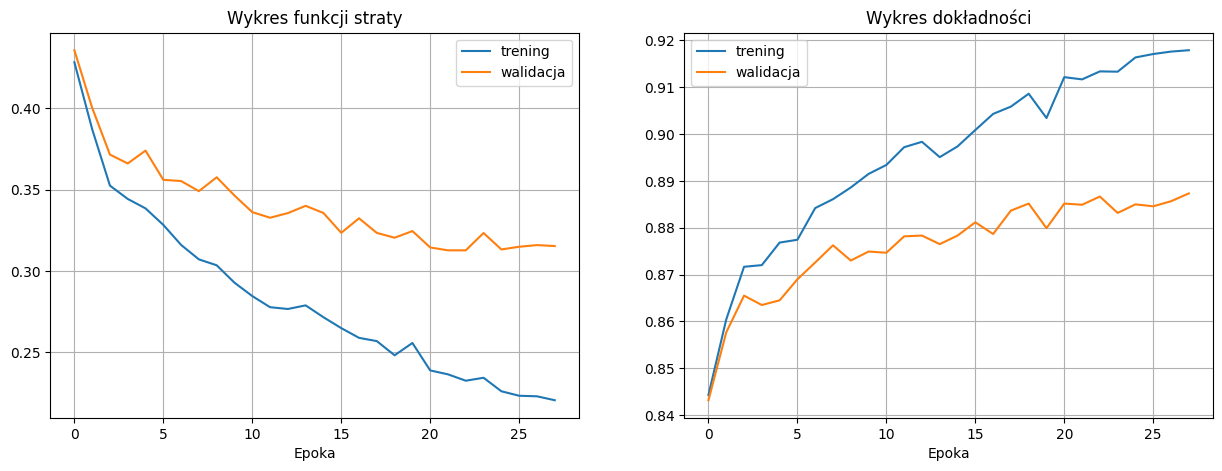

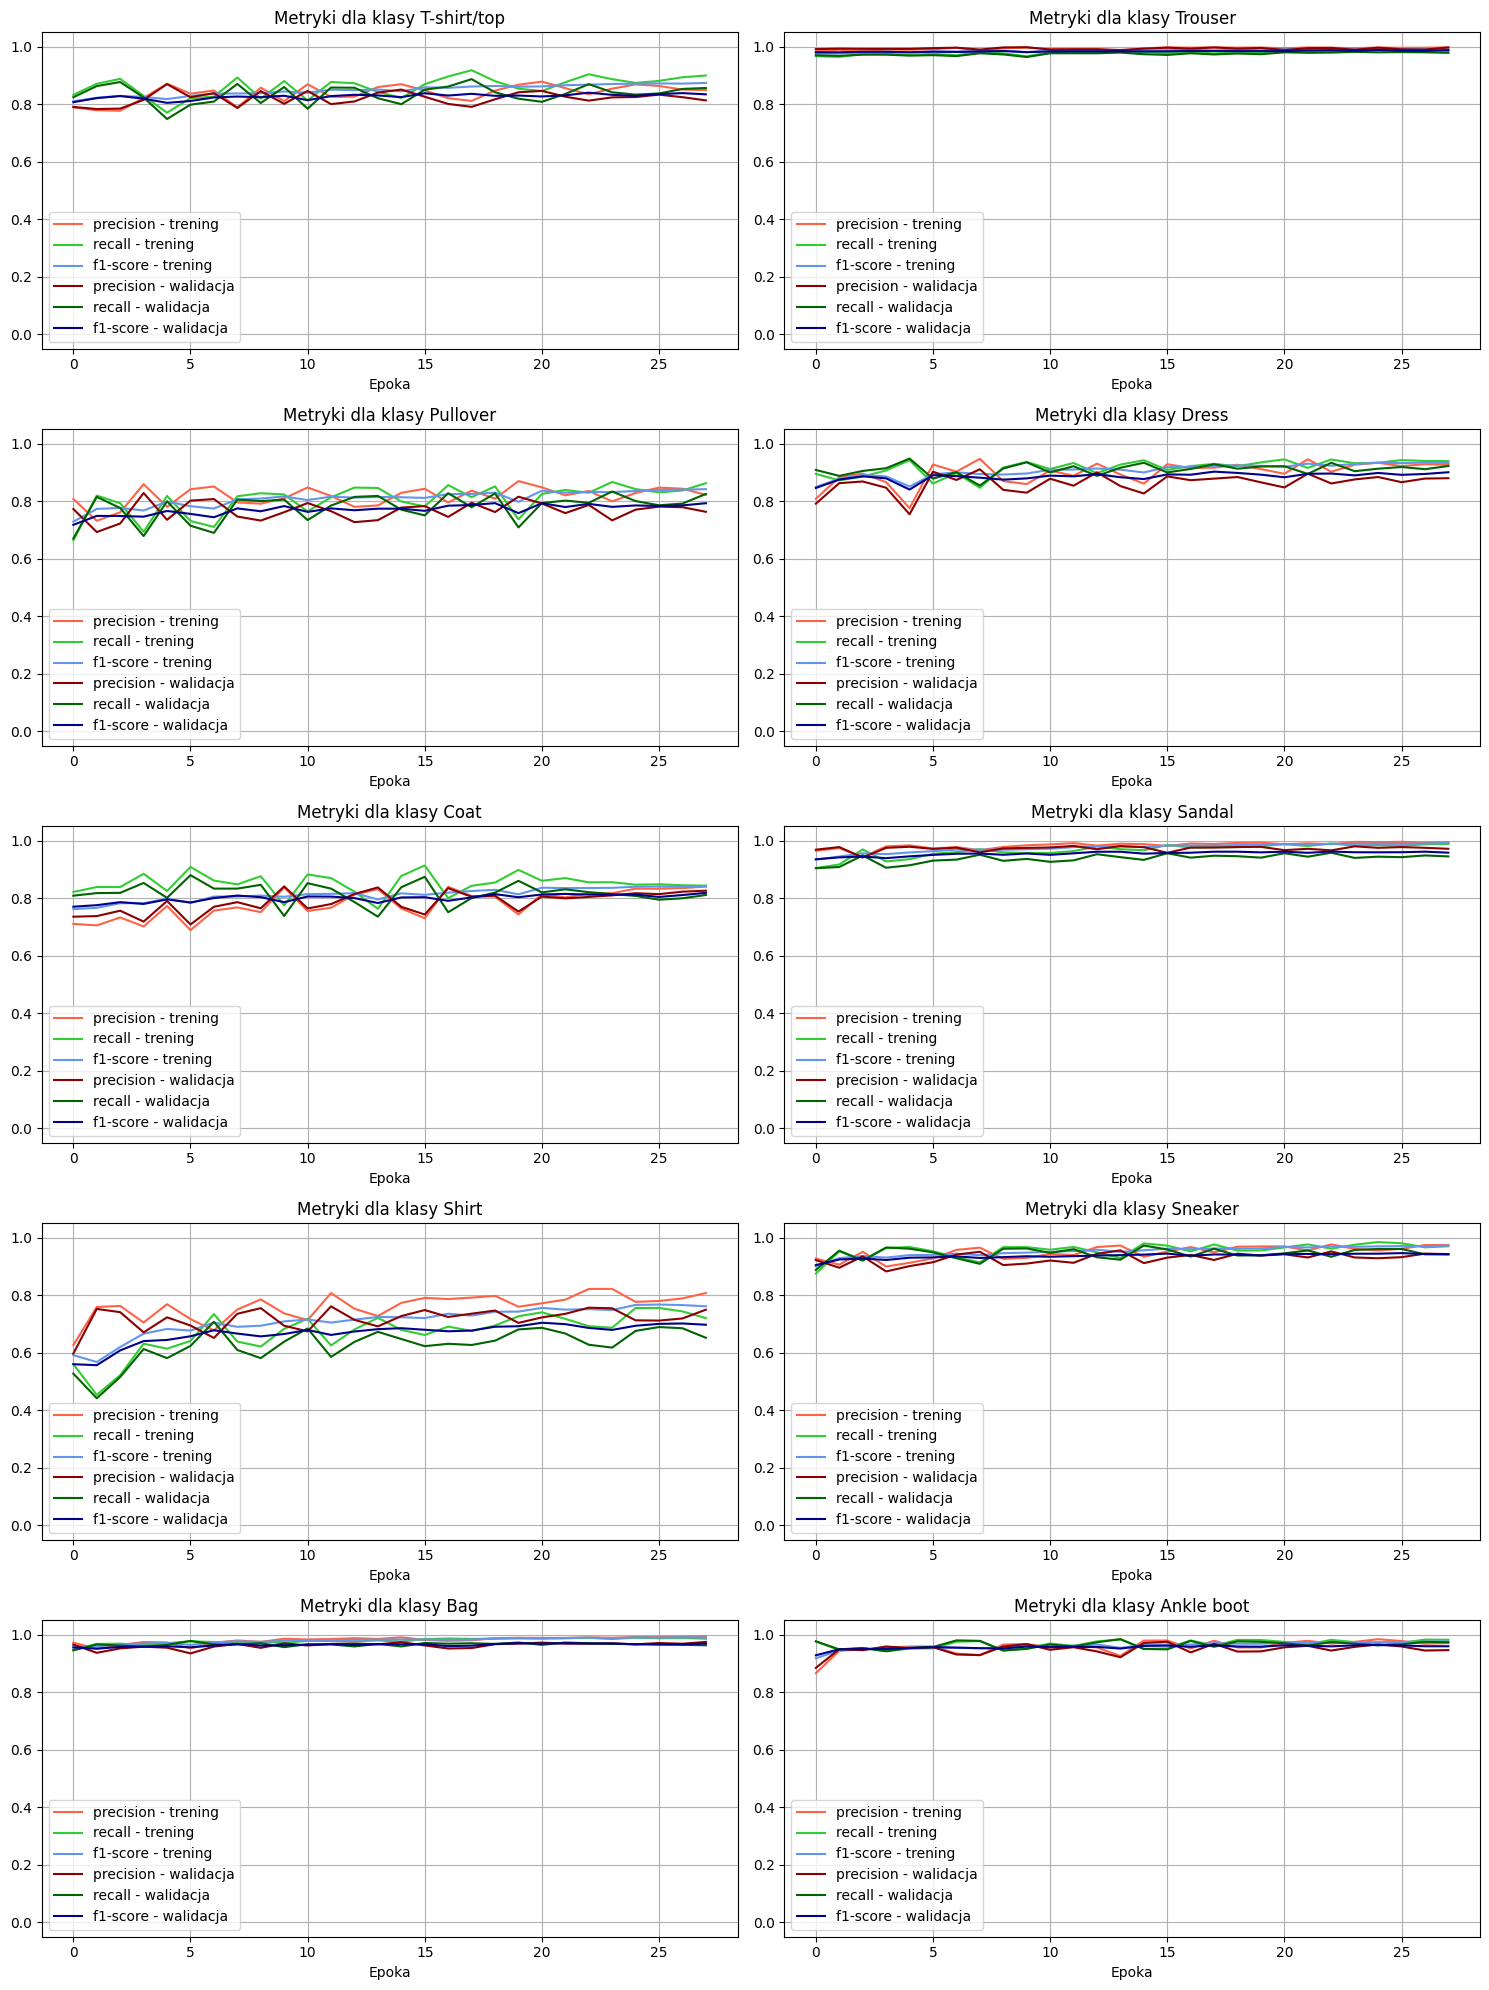

In [ ]:
# +scheduler with Adam
mlp = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_num/2, eta_min=0.0002)

trainer = TrainingClass(mlp, device, nn.CrossEntropyLoss(), optimizer, early_stopping=True, scheduler=scheduler)
tr_losses9, val_losses9, tr_metrics9, val_metrics9, tr_accuracies9, val_accuracies9 = trainer.training_loop(epochs_num, "model-scheduled-adam")

create_loss_and_accuracy_plot(tr_losses9, val_losses9, tr_accuracies9, val_accuracies9)
create_metrics_plot(tr_metrics9, val_metrics9)

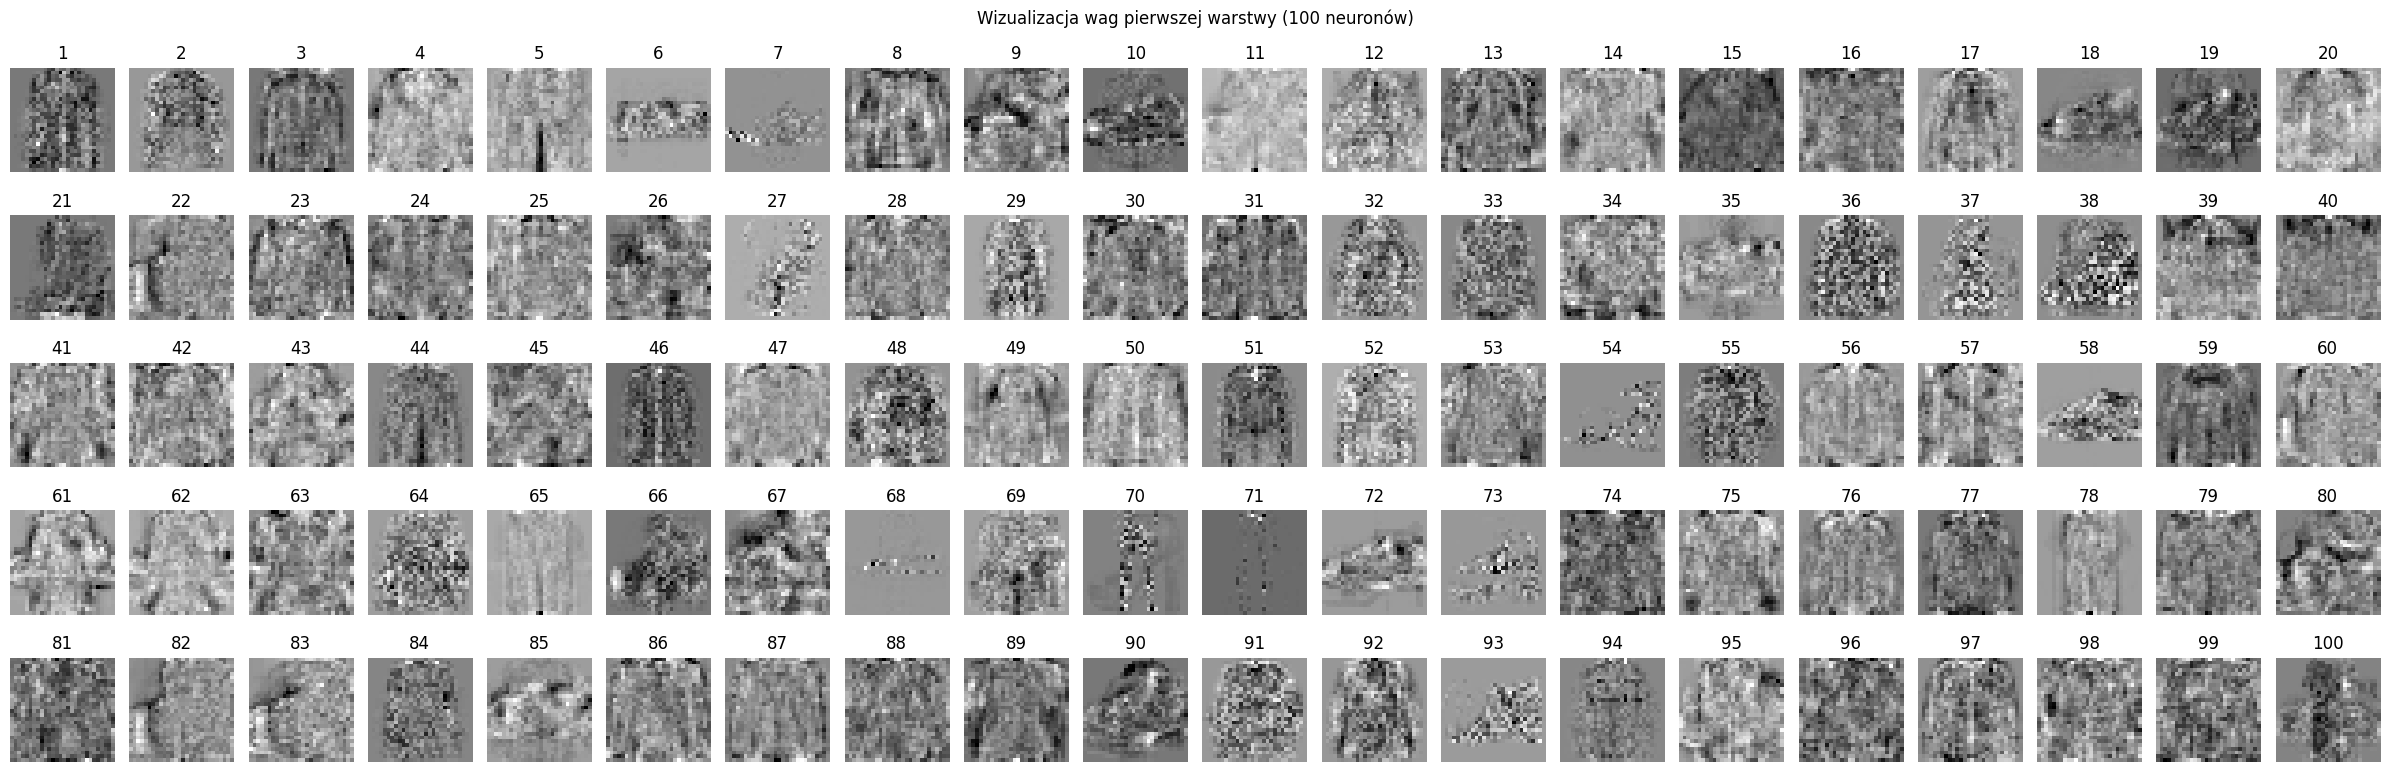

In [ ]:
mlp_visualize = ParametrizedMLP([100, 50], dropout=0.25, batch_norm=True)

weights_path = '/content/drive/MyDrive/mlp-models/model-scheduled-adam_weights.pth'
mlp_visualize.load_state_dict(torch.load(weights_path, map_location=device))
mlp_visualize.eval()

plt.figure(figsize=(24, 8))
plt.suptitle(f"Wizualizacja wag pierwszej warstwy (100 neuronów)")
visualize_layer_weights(mlp_visualize.layers[1], 100, [5, 20])

# Podsumowanie

W zrealizowanym zadaniu sprawdzone zostało działanie wybranych dobrych praktyk na proces trenowania modelu, takich jak early stopping, modyfikacja architektury, regularyzacja, normalizacja batch'y, dropout oraz scheduler do współczynnika uczenia. Spośród wymienionych praktyk najbardziej przydatne okazały się early stopping oraz scheduler.
<br><Br>
Co do potencjalnych uwag to myślę, że na następny raz lepiej byłoby chyba zwiększyć `patience` w early stoppingu, bo sprawdziłem teraz że typowo powinna wynosić powyżej 10 a ja miałem tylko 5, ale końcowo raczej cel ćwiczenia został zrealizowany to nie ma co odpalać wszystkiego od nowa.